# Bottled Gazpacho Market Research 4 (0 - 4 scale)

I don't know about you, but I love Gazpacho. In Spain they sell those delicacies bottled in supermarkets. But what about the rest of the world? How sad I am eveytime I go to the supermarket and none of that elixir is available. Here's the wonderful sight that Spaniards take for granted, while everyone else can only dream of:

![gazpacho](./images/spanish_bottled_gazpacho.jpg)

No more! This stops here! Or so I hope. Let's perform some **simulated market research** to find out if there is a market for Gazpacho in the rest of the world.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe import config_manager
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler

from tinytroupe.validation import SimulationExperimentEmpiricalValidator, SimulationExperimentDataset, validate_simulation_experiment_empirically


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: C:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: C:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.5.1
Current date and time (local): 2025-07-26 13:45:52
Current date and time (UTC):   2025-07-26 16:45:52

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4.1-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 32000
temperature = 1.5
freq_penalty = 0.1
presence_penalty = 0.1
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_n

In [2]:
#config_manager.update("action_generator_enable_quality_checks", True)
#config_manager.update("action_generator_quality_threshold", 6)

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [3]:
control.begin("bottled_gazpacho_market_research_4.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [4]:
target_nationality = "American"
population_size = 50

additional_demographic_specification = f"""
BESIDES other dimensions infered from the population demographic data (i.e., make sure those are still present), 
ensure these ADDITIONAL sampling dimensions are present, which must be as realistic as possible:
  - general attitude: from positive to negative, from optimistic to pessimistic, from open-minded to closed-minded
  - education: from the completely illiterate (can't even talk properly) to the highest scientist
  - culinary tastes: from traditional to modern, from spicy to mild, from vegetarian to meat-based
  - shopping habits: from frequent to occasional, from online to in-store, from frugal to extravagant
  - health consciousness: from health-focused to indulgent, from organic to conventional
  - attitude towards new products: from open-minded to skeptical, from adventurous to conservative
  - cultural influences: from local to global, from traditional to contemporary, from diverse to homogeneous
  - travel habits: from frequent travelers to homebodies, from local to international, from adventurous to cautious
  - cultural background: from diverse to homogeneous, from traditional to modern, from local to global
  - lifestyle: from active to sedentary, from urban to rural, from minimalist to extravagant

Each of these additional dimensions MUST have AT LEAST 10 values. 
For all of these, YOU MUST provide long, detailed sentences that describe the values in each dimension. NOT short
words. We need EACH value to be VERY detailed.

Make sure you also include EXTREME values so that we can properly capture even edge cases. We want a WIDE
range of different people and tastes!
"""
  

Should we also compute the other nationalities? This might take a while, so we leave it as an option.

In [5]:
compute_other_nationalities = True

Descriptions and standard questions for the survey.

In [6]:
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please present yourself and also list your top-10 interests?
    """

interviewer_main_question =\
    """ 
    Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with tomatoes, cucumbers, peppers, and olive oil. 
    We are considering offering it in supermarkets near you.

    Would you consider purchasing ready-to-drink bottled gazpacho if it was available at your local supermarket? How much do you like this idea? 

    Please rate your propensity of purchasing it (from 1 to 5), where:
       - 1: would NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
       - 2: very unlikely, but not impossible.
       - 3: maybe I would buy it, not sure.
       - 4: it is very likely.
       - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
    """

inner_monologue =\
    """
    I will be honest as I understand they are not here to judge me, but just to learn from me. 
    Such choices depend on many factors, but I will make my best guess, considering my current 
    situation in life, location, job and interests. I will not refrain from giving extreme answers, 
    such as 1 or 5, if that's how I really feel, as this exercise requires me to be honest, human and realistic.

    Now I **must** first THINK deeply about the question, consider all the factors that might influence my decision,
    and only then I will TALK with my response to the question as best, as detailed and as honestly as I can.
    """

Common mechaniss.

In [7]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product. A person rate his/her propensity from 1 (would NEVER buy) to 5 (would CERTAINLY buy it)." ,
                                     situation="Agent was asked to rate their interest in a bottled Gazpacho. They can respond with a propensity score from 1 (would NEVER buy) to 5 (would CERTAINLY buy it).", 
                                     fields=["name", "response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as '1', '2', '3', '4', '5' or 'N/A'(if there is no response or you cannot determine the precise response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [8]:
def is_there_a_good_market(df, positive_threshold=0.1, negative_threshold=0.5):
    # Convert responses to strings for consistent handling
    df_copy = df.copy()
    df_copy["response"] = df_copy["response"].astype(str)
    
    # Get counts and calculate percentages
    counts = df_copy["response"].value_counts()
    total = counts.sum()
    percentage = counts / total
    
    # Calculate percentages by rating category (using 1-5 scale)
    percentage_positive = percentage.get("4", 0) + percentage.get("5", 0)
    percentage_neutral = percentage.get("3", 0)
    percentage_negative = percentage.get("1", 0) + percentage.get("2", 0)
    percentage_na = percentage.get("N/A", 0)
    
    # Print the analysis
    print(f"Percentage of positive responses (4-5): {percentage_positive:.2%}")
    print(f"Percentage of neutral responses (3): {percentage_neutral:.2%}")
    print(f"Percentage of negative responses (1-2): {percentage_negative:.2%}")
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # also compute the mean and standard deviation of the responses
    df_copy["response"] = pd.to_numeric(df_copy["response"], errors='coerce')
    mean_response = df_copy["response"].mean()
    std_response = df_copy["response"].std()

    print(f"Mean response: {mean_response:.2f}")
    print(f"Standard deviation of responses: {std_response:.2f}")

    # Decision based on thresholds
    if percentage_positive > positive_threshold and percentage_negative < negative_threshold:
        print("VERDICT: There is a good market for bottled gazpacho.")
        return True
    else:
        print("VERDICT: There is not a good market for bottled gazpacho.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [9]:
factory = TinyPersonFactory.create_factory_from_demography("./information/populations/usa.json", 
                                                           population_size=population_size, 
                                                           additional_demographic_specification=additional_demographic_specification)

In [10]:
people = factory.generate_people(population_size, verbose=True)

In [11]:
factory.sampling_dimensions

{'sampling_space_description': 'A detailed, representative sampling space of the United States population, capturing demographic, socioeconomic, cultural, personality, political, and lifestyle diversity as specified by the provided demographic data and directives.',
 'dimensions': [{'name': 'age', 'range': [0, 100]},
  {'name': 'gender', 'values': {'Male': 0.492, 'Female': 0.508}},
  {'name': 'racial_and_ethnic_composition',
   'values': {'White (Non-Hispanic)': 0.571,
    'Hispanic or Latino': 0.194,
    'Black or African American': 0.121,
    'Asian': 0.07,
    'Two or More Races': 0.029,
    'American Indian or Alaska Native': 0.013,
    'Native Hawaiian or Pacific Islander': 0.002}},
  {'name': 'educational_attainment',
   'values': {'Completely illiterate, unable to communicate effectively in spoken or written English': 0.1,
    'Basic literacy and primary education, limited reading and writing skills': 0.2,
    'High school graduate or equivalent, able to engage in everyday readi

In [12]:
factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Middle-aged urban White (Non-Hispanic) professionals with higher education and upper-middle income, politically Democrat or Independent, open to new experiences and moderately health-conscious.',
  'sampled_values': {'age': [35, 55],
   'gender': ['Male', 'Female'],
   'racial_and_ethnic_composition': ['White (Non-Hispanic)'],
   'educational_attainment': ["Bachelor's degree or higher, including advanced degrees and scientists"],
   'household_income': ['$100,000-$199,999, upper-middle income with comfortable lifestyle'],
   'geographic_distribution': ['Urban, living in densely populated metropolitan areas with diverse amenities and cultural offerings'],
   'region': ['Northeast', 'West'],
   'marital_status': ['Married', 'Never Married'],
   'employment_status': ['Labor Force Participant'],
   'personality_traits': ['Maintains a high openness to new experiences, embracing novel ideas and cultural diversity, often found in states like New York

We can request a specific number of people.

A quick look into the folks that were created:

In [13]:
factory.generated_minibios

['Clifton James McAllister is a 58 year old Construction Laborer, American, currently living in Rural Tennessee, South, USA. Clifton is a humble and modest man who values tradition and stability, preferring the familiar rhythms of rural life over change or novelty. He enjoys simple outdoor activities like fishing and camping, often sharing stories and family recipes that connect him to his heritage. Deeply rooted in his Christian faith, he actively participates in his local church community and finds comfort in routine, quiet reflection, and close relationships with family and longtime friends. Despite some health challenges and financial worries, Clifton approaches life with patience and a cautious, practical mindset, always striving to support those he cares about.',
 'Isabela Fernanda Morales Cruz is a 29 year old Healthcare Support Worker, American, currently living in Los Angeles, California. Beyond her dedicated work at the clinic, Isabela is a vibrant and sociable individual who

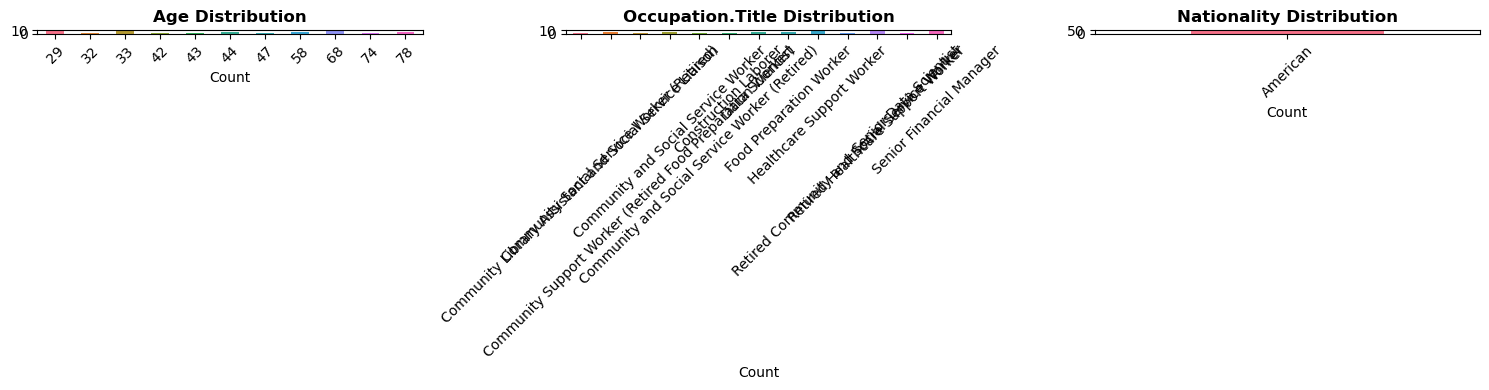

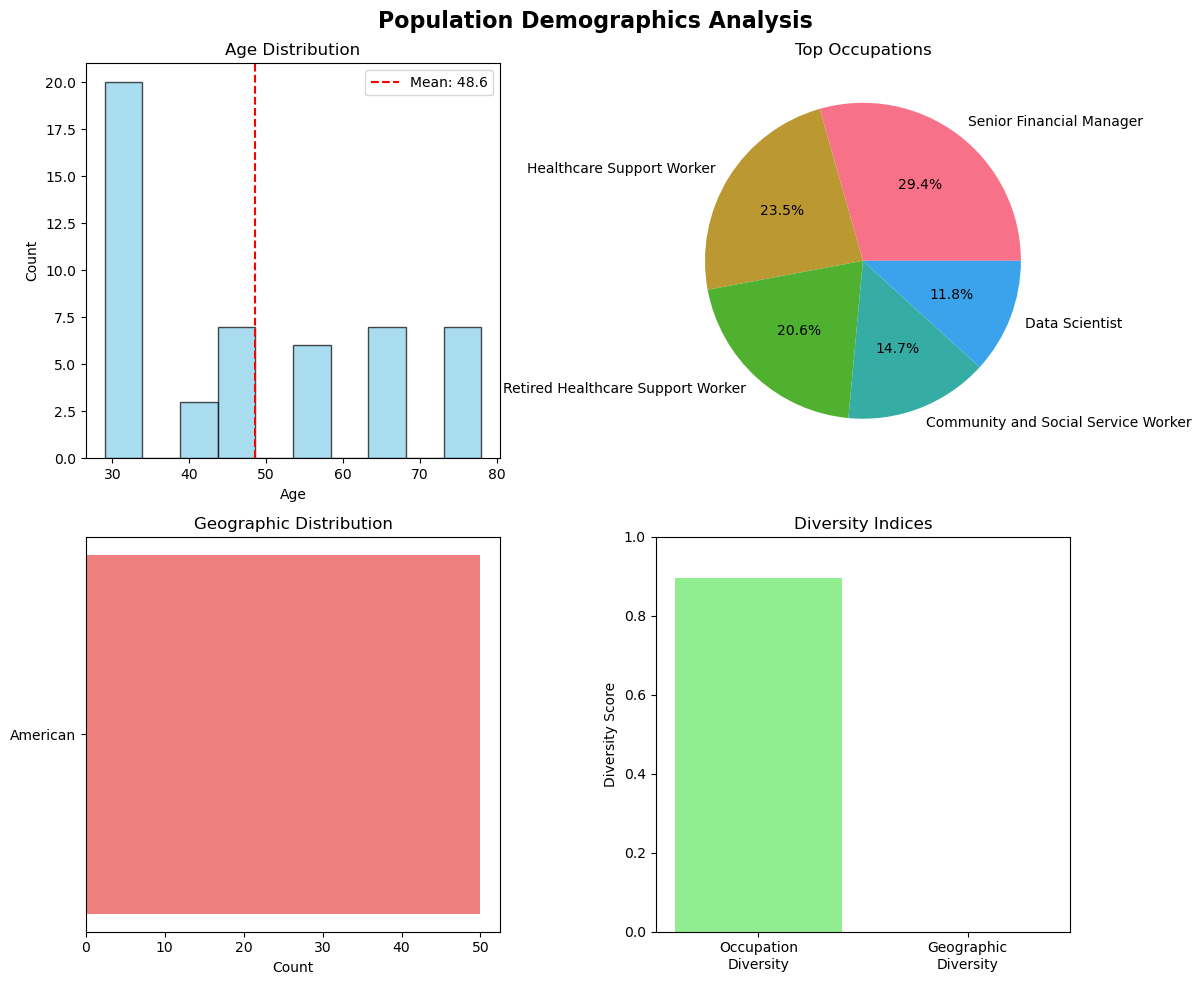

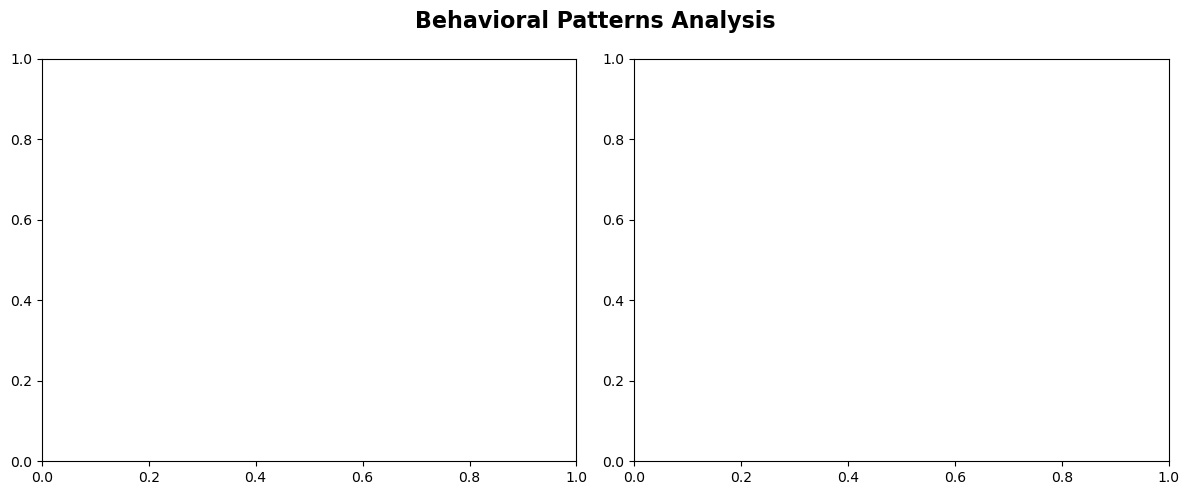

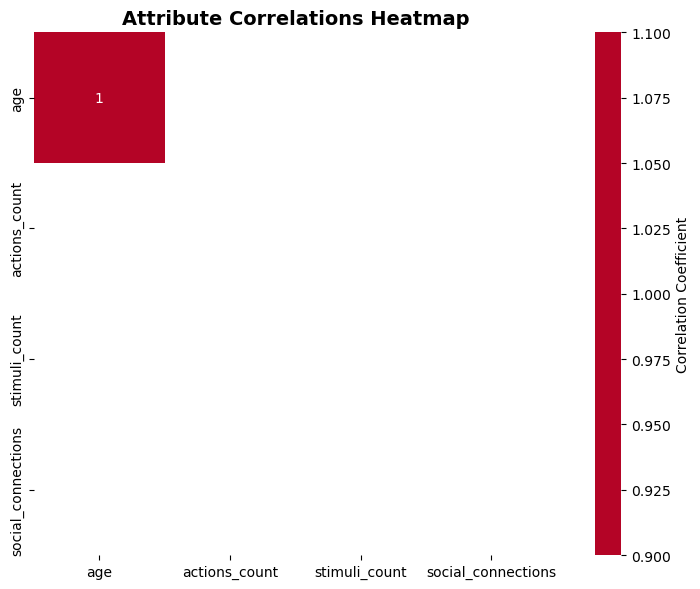

{'distributions': {'age': 29     8
  32     2
  33    10
  42     2
  43     1
  44     6
  47     1
  58     6
  68     7
  74     1
  78     6
  Name: count, dtype: int64,
  'occupation.title': Community Library Assistant and Social Service Liaison         1
  Community Social Service Worker (Retired)                      4
  Community Support Worker (Retired Food Preparation Worker)     1
  Community and Social Service Worker                            5
  Community and Social Service Worker (Retired)                  1
  Construction Laborer                                           2
  Data Scientist                                                 4
  Food Preparation Worker                                        4
  Healthcare Support Worker                                      8
  Retired Community and Social Service Worker                    1
  Retired Healthcare Support Worker                              7
  Senior Data Scientist                                          2
  

In [14]:
profiler = Profiler()
profiler.profile(people)

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [15]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [16]:
market = TinyWorld(f"Target audience ({target_nationality})", people, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [17]:
market.broadcast(interviewer_introduction)
market.broadcast(interviewer_main_question)
market.broadcast_thought(inner_monologue)

USER --> Clifton James McAllister: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> Isabela Fernanda Morales Cruz

       + --> Aiyana Marisol Redfeather-Montoya

       + --> ...others...

USER --> Clifton James McAllister: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 1 to 5), where:        - 1: would
          > NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how
          > you feel, as it is part of the human experience.        - 2: very unlikely, but not
          > impossible.        - 3: maybe I would buy it, not sure.        - 4: it is very likely.
          > - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive
          > answer if it is how you feel, as it is part of the human experience.

       + --> Isabela Fernanda Morales Cruz

       + --> Aiyana Marisol Redfeather-Montoya

       + --> ...others...

Clifton James McAllister --> Clifton James McAllister: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Isabela Fernanda Morales Cruz --> Isabela Fernanda Morales Cruz: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Aiyana Marisol Redfeather-Montoya --> Aiyana Marisol Redfeather-Montoya: [THOUGHT] 
                                       >      I will be honest as I understand they are not here to
                                       > judge me, but just to learn from me.      Such choices
                                       > depend on many factors, but I will make my best guess,
                                       > considering my current      situation in life, location,
                                       > job and interests. I will not refrain from giving extreme
                                       > answers,      such as 1 or 5, if that's how I really feel,
                                       > as this exercise requires me to be honest, human and
                                       > realistic.      Now I **must** first THINK deeply about the
                                       > question, consider all the factors that might influence my
                                       > decision,     and only then I will TALK with my response to
                                       > the question as best, as detailed and as honestly as I can.

Evelyn Grace McAllister --> Evelyn Grace McAllister: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Isabel Marquez Santoro --> Isabel Marquez Santoro: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Eleanor Margaret Winslow-Sterling --> Eleanor Margaret Winslow-Sterling: [THOUGHT] 
                                       >      I will be honest as I understand they are not here to
                                       > judge me, but just to learn from me.      Such choices
                                       > depend on many factors, but I will make my best guess,
                                       > considering my current      situation in life, location,
                                       > job and interests. I will not refrain from giving extreme
                                       > answers,      such as 1 or 5, if that's how I really feel,
                                       > as this exercise requires me to be honest, human and
                                       > realistic.      Now I **must** first THINK deeply about the
                                       > question, consider all the factors that might influence my
                                       > decision,     and only then I will TALK with my response to
                                       > the question as best, as detailed and as honestly as I can.

Clara Meredith Winslow --> Clara Meredith Winslow: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Sora Emi Takahashi --> Sora Emi Takahashi: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.

Eleanor Vivian Prescott-Sullivan --> Eleanor Vivian Prescott-Sullivan: [THOUGHT] 
                                      >      I will be honest as I understand they are not here to
                                      > judge me, but just to learn from me.      Such choices
                                      > depend on many factors, but I will make my best guess,
                                      > considering my current      situation in life, location, job
                                      > and interests. I will not refrain from giving extreme
                                      > answers,      such as 1 or 5, if that's how I really feel,
                                      > as this exercise requires me to be honest, human and
                                      > realistic.      Now I **must** first THINK deeply about the
                                      > question, consider all the factors that might influence my
                                      > decision,     and only then I will TALK with my response to
                                      > the question as best, as detailed and as honestly as I can.

Aiyana Soleil Redhawk-Montoya --> Aiyana Soleil Redhawk-Montoya: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Eleanor Vivian Prescott --> Eleanor Vivian Prescott: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Leroy Darnell McCoy Jr. --> Leroy Darnell McCoy Jr.: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Clifton Ray Hargrove --> Clifton Ray Hargrove: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Mabel Louise Grangerton --> Mabel Louise Grangerton: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Harold Amos Whitfield --> Harold Amos Whitfield: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Jordan Kai Redfeather-Montoya --> Jordan Kai Redfeather-Montoya: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Marisol Elena Vargas --> Marisol Elena Vargas: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Clara Jeanette Simmons --> Clara Jeanette Simmons: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Emiko Hana Takahashi --> Emiko Hana Takahashi: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Martha Louise Granger --> Martha Louise Granger: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Martha Ellen Granger --> Martha Ellen Granger: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Eleanor Claire Whitman-Sullivan --> Eleanor Claire Whitman-Sullivan: [THOUGHT] 
                                     >      I will be honest as I understand they are not here to
                                     > judge me, but just to learn from me.      Such choices depend
                                     > on many factors, but I will make my best guess, considering
                                     > my current      situation in life, location, job and
                                     > interests. I will not refrain from giving extreme answers,
                                     > such as 1 or 5, if that's how I really feel, as this exercise
                                     > requires me to be honest, human and realistic.      Now I
                                     > **must** first THINK deeply about the question, consider all
                                     > the factors that might influence my decision,     and only
                                     > then I will TALK with my response to the question as best, as
                                     > detailed and as honestly as I can.

Avery Lani Kaimana --> Avery Lani Kaimana: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.

Mariana Isabel Torres Vega --> Mariana Isabel Torres Vega: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Harriet Mae Caldwell --> Harriet Mae Caldwell: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Jalen Kaiya Redhawk --> Jalen Kaiya Redhawk: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Jinsoo Min Park --> Jinsoo Min Park: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests. I will not refrain from giving extreme answers,      such as 1
                     > or 5, if that's how I really feel, as this exercise requires me to be honest,
                     > human and realistic.      Now I **must** first THINK deeply about the
                     > question, consider all the factors that might influence my decision,     and
                     > only then I will TALK with my response to the question as best, as detailed
                     > and as honestly as I can.

Ethel Mae Langston --> Ethel Mae Langston: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.

Sora Min-Jae Takahashi --> Sora Min-Jae Takahashi: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Mabel Louise Thornton --> Mabel Louise Thornton: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Madeline Claire Thornton --> Madeline Claire Thornton: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Dorothy Jeanette Hargrove --> Dorothy Jeanette Hargrove: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Lucía Marisol Vega Ortega --> Lucía Marisol Vega Ortega: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Eleanor Margaret Winslow --> Eleanor Margaret Winslow: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Aiyana Soleil Redfeather --> Aiyana Soleil Redfeather: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Aiko Mei Nakamura --> Aiko Mei Nakamura: [THOUGHT] 
                       >      I will be honest as I understand they are not here to judge me, but
                       > just to learn from me.      Such choices depend on many factors, but I will
                       > make my best guess, considering my current      situation in life,
                       > location, job and interests. I will not refrain from giving extreme
                       > answers,      such as 1 or 5, if that's how I really feel, as this exercise
                       > requires me to be honest, human and realistic.      Now I **must** first
                       > THINK deeply about the question, consider all the factors that might
                       > influence my decision,     and only then I will TALK with my response to
                       > the question as best, as detailed and as honestly as I can.

Clarence Darnell McBride --> Clarence Darnell McBride: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Sofia Elena Ramirez Cruz --> Sofia Elena Ramirez Cruz: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Harold Eugene Whitaker --> Harold Eugene Whitaker: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Eleanor Grace Whitfield --> Eleanor Grace Whitfield: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Mildred Agnes Hargrove --> Mildred Agnes Hargrove: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Isabela Marquez Delgado --> Isabela Marquez Delgado: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Leroy Darnell McCoy --> Leroy Darnell McCoy: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Dorothy Annette Caldwell --> Dorothy Annette Caldwell: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Graham Everett Langston --> Graham Everett Langston: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Valeria Camacho Herrera --> Valeria Camacho Herrera: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Clara Louise McAllister --> Clara Louise McAllister: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Morgan Elise Whitman --> Morgan Elise Whitman: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Kaiwen Lin Chen --> Kaiwen Lin Chen: [THOUGHT] 
                     >      I will be honest as I understand they are not here to judge me, but just
                     > to learn from me.      Such choices depend on many factors, but I will make
                     > my best guess, considering my current      situation in life, location, job
                     > and interests. I will not refrain from giving extreme answers,      such as 1
                     > or 5, if that's how I really feel, as this exercise requires me to be honest,
                     > human and realistic.      Now I **must** first THINK deeply about the
                     > question, consider all the factors that might influence my decision,     and
                     > only then I will TALK with my response to the question as best, as detailed
                     > and as honestly as I can.

Evelyn Mae Jefferson --> Evelyn Mae Jefferson: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

In [18]:
market.run(1)

───────────────────────────────────── Target audience (American) step 1 of 1 ──────────────────────────────────────

Eleanor Vivian Prescott acts: [THINK] 
                             > Considering my lifestyle in Brooklyn, my culinary interests, and my
                             > preference for fresh, wholesome foods, I need to evaluate how a
                             > ready-to-drink bottled gazpacho fits into my routine. I enjoy
                             > experimenting with traditional American recipes and fusion cuisine,
                             > and I appreciate convenience but dislike overly processed meals.
                             > Gazpacho, being a cold vegetable soup from Spain, sounds healthy and
                             > refreshing, which aligns with my moderate physical activity and
                             > balanced diet. However, I must consider if I would actually purchase
                             > it regularly or just occasionally. Given these factors, I am leaning
                             > towards a positive but cautious interest in buying it.

Eleanor Vivian Prescott-Sullivan acts: [THINK] 
                                      > Considering my lifestyle in Brooklyn, my culinary interests,
                                      > and my preference for fresh, local produce, I need to
                                      > evaluate how a ready-to-drink bottled gazpacho fits into my
                                      > dietary habits. I appreciate traditional recipes and quality
                                      > ingredients, and I tend to avoid overly processed foods.
                                      > However, convenience is important given my busy schedule. I
                                      > must weigh these factors carefully before responding.

Isabela Fernanda Morales Cruz acts: [THINK] 
                                   > I need to consider my personal preferences, cultural
                                   > background, and lifestyle when deciding about buying ready-to-
                                   > drink bottled gazpacho. Gazpacho is a cold vegetable soup from
                                   > Spain, and while I enjoy trying new foods, I usually prefer
                                   > bold and spicy flavors like chipotle and jalapeño. Also, I like
                                   > fresh, homemade dishes more than processed or bottled ones.
                                   > However, convenience is important given my busy schedule at the
                                   > clinic. I should weigh these factors carefully before giving my
                                   > rating.

Isabel Marquez Santoro acts: [THINK] 
                            > Okay, so gazpacho is a cold vegetable soup from Spain, made with
                            > tomatoes, cucumbers, peppers, and olive oil. I like fresh and bold
                            > flavors, especially spicy ones, but gazpacho is not something I
                            > usually eat or think about. Since it's cold and vegetable-based, it
                            > might be refreshing, but I wonder if it fits my taste preferences.
                            > Also, I shop mostly at local markets and specialty stores, and I
                            > prefer fresh ingredients over processed or bottled products. However,
                            > if it was convenient and tasty, maybe I'd consider it. I should rate
                            > my likelihood honestly based on this.

Sora Emi Takahashi acts: [THINK] 
                        > Considering my lifestyle in San Francisco, my preference for fresh and
                        > organic foods, and my interest in international cuisines, I think I would
                        > be open to trying ready-to-drink bottled gazpacho. However, since I prefer
                        > dishes with bold and spicy flavors, a traditional gazpacho might not fully
                        > satisfy my taste. I would rate my propensity to purchase it as a 3, maybe
                        > I would buy it, but I'm not entirely sure. It would depend on the quality,
                        > flavor profile, and how well it fits into my diet and preferences.

Clara Meredith Winslow acts: [THINK] 
                            > Considering my lifestyle in Brooklyn, my culinary interests, and my
                            > preference for fresh, quality foods, I need to evaluate how a ready-
                            > to-drink bottled gazpacho fits into my habits. I enjoy traditional
                            > American comfort foods and fusion dishes, but I also dislike overly
                            > processed foods. Gazpacho is a cold vegetable soup from Spain, which
                            > aligns with my openness to diverse cuisines. However, I am cautious
                            > about convenience foods that might lack nutritional value or
                            > freshness. Given these factors, I should rate my propensity to
                            > purchase bottled gazpacho honestly, balancing my curiosity and health-
                            > consciousness.

Aiyana Soleil Redhawk-Montoya acts: [THINK] 
                                   > Considering my lifestyle in Brooklyn, my preferences for fresh,
                                   > natural foods, and my interest in sustainable and ethical
                                   > shopping, I think about how gazpacho fits into that. I enjoy
                                   > fusion cuisine and trying new flavors, but I also dislike
                                   > overly processed foods. Gazpacho is a cold vegetable soup,
                                   > which sounds refreshing and healthy, especially in warmer
                                   > months. However, I might be cautious about ready-to-drink
                                   > bottled versions because of concerns about preservatives or
                                   > packaging waste. Overall, I feel moderately positive about the
                                   > idea but would want to check the ingredients and packaging
                                   > before deciding to buy it.

Eleanor Vivian Prescott acts: [TALK] 
                             > Thank you for explaining the product. Considering my interest in
                             > culinary arts and preference for fresh, wholesome foods, I would rate
                             > my propensity to purchase ready-to-drink bottled gazpacho as a 3. I
                             > might buy it occasionally, especially during warmer months or when I
                             > want a convenient, healthy option, but I would want to ensure it
                             > aligns with my standards for quality and freshness.

Leroy Darnell McCoy Jr. acts: [THINK] 
                             > Well now, I gotta think on this here gazpacho business. It ain't
                             > somethin' I grew up with or usually eat 'round these parts. I like my
                             > food warm and home-cooked, like cornbread, fried chicken, and sweet
                             > potato pie. Cold vegetable soups just ain't my style, and I reckon I
                             > might be a bit wary of newfangled foods like that bottled gazpacho.
                             > But I gotta be honest and consider if it might be handy or tasty
                             > enough to try once in a while. I reckon I might lean towards not
                             > buyin' it, but I gotta weigh it all out proper-like before I say for
                             > sure.

Aiyana Marisol Redfeather-Montoya acts: [THINK] 
                                       > Considering my lifestyle in Portland, my interest in
                                       > sustainable and ethical food choices, and my preference for
                                       > fresh, locally sourced ingredients, I need to evaluate how
                                       > a ready-to-drink bottled gazpacho fits into that. Gazpacho
                                       > is a cold vegetable soup, which sounds refreshing and
                                       > healthy, aligning somewhat with my dietary preferences.
                                       > However, I usually prefer fresh or homemade foods over
                                       > processed or bottled ones. Also, I dislike processed foods
                                       > with artificial ingredients, so I'd want to know more about
                                       > the product's ingredients and sourcing. Given these
                                       > factors, I think my propensity to purchase would be
                                       > moderate but leaning towards unlikely unless the product
                                       > meets my standards for sustainability and quality.

Eleanor Margaret Winslow-Sterling acts: [THINK] 
                                       > Considering my lifestyle in Brooklyn, my culinary
                                       > preferences, and my general approach to food, I appreciate
                                       > fresh, high-quality ingredients and tend to avoid overly
                                       > processed meals. Gazpacho, being a cold vegetable soup with
                                       > fresh ingredients, aligns somewhat with my interest in
                                       > fusion cuisine and healthy eating. However, I prefer
                                       > preparing meals myself or buying from trusted sources
                                       > rather than ready-to-drink bottled products. I must weigh
                                       > convenience against quality and authenticity. Given this, I
                                       > would rate my propensity to purchase bottled gazpacho as a
                                       > 3, maybe I would buy it, but I'm not sure. I remain open to
                                       > trying it if the product meets my standards and is
                                       > available at a local supermarket.

Evelyn Grace McAllister acts: [THINK] 
                             > I reckon I gotta be honest 'bout this gazpacho thing. It ain't
                             > somethin' we usually have 'round here, and cold soups just ain't my
                             > cup o' tea, especially ready-to-drink bottled ones. I prefer my food
                             > warm and home-cooked, like the fried chicken and biscuits I make at
                             > the diner. Plus, I ain't too fond of newfangled foods or things that
                             > seem fancy or outta place. But I gotta think 'bout if maybe some
                             > folks might like it, even if I don't. Still, for me, I think I'd lean
                             > towards not buyin' it at all.

Clifton James McAllister acts: [THINK] 
                              > Well, I gotta think 'bout this here gazpacho thing. Ain't never had
                              > it before, and it sounds kinda fancy with them cold blended veggies.
                              > I ain't much for newfangled foods or strong spices, and I like my
                              > meals simple and home-cooked. Plus, I ain't too keen on fancy or
                              > processed stuff. But if it was easy to grab at the store and didn't
                              > cost too much, maybe I'd give it a try just to see. Still, I reckon
                              > I'd be more likely to stick with what I know and trust. So, I gotta
                              > be honest and say I'm more on the side of unlikely to buy it, but I
                              > won't say never. Givin' it a 2 seems about right for me.

Isabela Fernanda Morales Cruz acts: [TALK] 
                                   > Honestly, I think I would rate my propensity to buy ready-to-
                                   > drink bottled gazpacho as a 2. I like trying new foods, but I
                                   > usually prefer bold and spicy flavors, and I tend to favor
                                   > fresh, homemade dishes over bottled ones. Convenience is
                                   > important, but I don't think gazpacho fits my usual taste
                                   > preferences. Still, I wouldn't completely rule it out if I saw
                                   > it at my local supermarket.

Isabel Marquez Santoro acts: [TALK] 
                            > Honestly, I think I'd rate my chance of buying ready-to-drink bottled
                            > gazpacho as a 2. I usually prefer fresh ingredients and cooking from
                            > scratch, especially with bold and spicy flavors I love. Bottled soups
                            > sometimes feel bland or processed to me, and I like to shop at local
                            > markets where I can see and touch the produce. But if it was tasty and
                            > convenient, maybe I'd give it a try now and then.

Eleanor Vivian Prescott-Sullivan acts: [TALK] 
                                      > Thank you for explaining the product. Considering my
                                      > preference for fresh, local, and minimally processed foods,
                                      > I would rate my propensity to purchase ready-to-drink
                                      > bottled gazpacho as a 2. While I appreciate the idea of
                                      > convenience, I am generally cautious about processed options
                                      > and prefer to prepare such dishes myself to ensure quality
                                      > and flavor.

Eleanor Vivian Prescott acts: [DONE] 

Isabela Fernanda Morales Cruz acts: [THINK] 
                                   > I need to consider my personal preferences, cultural
                                   > background, and lifestyle when deciding about buying ready-to-
                                   > drink bottled gazpacho. Gazpacho is a cold vegetable soup from
                                   > Spain, and while I enjoy trying new foods, I usually prefer
                                   > bold and spicy flavors like chipotle and jalapeño. Also, I like
                                   > fresh, homemade dishes more than processed or bottled ones.
                                   > However, if it were convenient and tasty, I might consider it
                                   > occasionally. Given my interest in international cuisines but
                                   > also my dislike for overly processed or bland foods, I think my
                                   > rating would be a 3, maybe I would buy it, but I'm not sure.

Isabel Marquez Santoro acts: [DONE] 

Aiyana Marisol Redfeather-Montoya acts: [THINK] 
                                       > Considering my lifestyle in Portland, my preferences for
                                       > fresh and sustainable foods, and my interest in fusion
                                       > cuisine, I think about how gazpacho fits into my diet. I
                                       > appreciate cold soups in summer and enjoy trying new
                                       > flavors, especially those with a cultural background.
                                       > However, I also prefer foods with natural ingredients and
                                       > minimal processing. I need to weigh the convenience of
                                       > ready-to-drink gazpacho against my preference for fresh,
                                       > homemade meals. Overall, I feel positive about the idea but
                                       > cautious about the product's quality and sourcing.

Aiyana Soleil Redhawk-Montoya acts: [TALK] 
                                   > Thanks for explaining gazpacho! Considering my love for fresh,
                                   > natural foods and sustainable choices, I'd rate my propensity
                                   > to buy ready-to-drink bottled gazpacho as a 3. I might try it
                                   > if the ingredients are wholesome and the packaging eco-
                                   > friendly, but I'd want to be sure it's not overly processed or
                                   > wasteful. It sounds refreshing, especially in summer, but I
                                   > stay cautious about convenience products.

Eleanor Margaret Winslow-Sterling acts: [TALK] 
                                       > Thank you for explaining the product. Considering my
                                       > preferences for fresh, high-quality ingredients and my
                                       > tendency to avoid overly processed foods, I would rate my
                                       > propensity to purchase ready-to-drink bottled gazpacho as a
                                       > 3. I might buy it if it meets my standards and is
                                       > conveniently available, but I'm not fully certain yet.

Sora Emi Takahashi acts: [TALK] 
                        > Thank you for explaining. Considering my preferences and lifestyle, I
                        > would rate my propensity to purchase ready-to-drink bottled gazpacho as a
                        > 3. I might buy it if the flavor suits me and it fits well with my diet,
                        > but I'm not entirely sure yet.

Eleanor Vivian Prescott-Sullivan acts: [TALK] 
                                      > Certainly, I am Eleanor Vivian Prescott-Sullivan, a Senior
                                      > Financial Manager at a leading multinational financial
                                      > services firm headquartered in Manhattan. I lead a team
                                      > responsible for managing corporate investment portfolios and
                                      > advising on mergers and acquisitions. I have a Bachelor of
                                      > Arts in Economics from Boston University and an MBA from the
                                      > University of California, Berkeley. My top 10 interests
                                      > include culinary arts, reading a wide range of literature,
                                      > attending cultural events, traveling to culturally rich
                                      > cities, community volunteer work focused on education and
                                      > economic empowerment, yoga and Pilates, exploring new
                                      > technologies, socializing with diverse friends and
                                      > colleagues, following current events and political
                                      > developments, and gardening small indoor plants and herbs.

Clara Meredith Winslow acts: [TALK] 
                            > Thank you for explaining the product. Considering my interest in
                            > culinary arts and preference for fresh, nutritious foods, I would rate
                            > my propensity to purchase ready-to-drink bottled gazpacho as a 3. I
                            > might buy it occasionally, especially if it is made with high-quality,
                            > natural ingredients and has an authentic flavor. However, I am
                            > cautious about processed foods and would want to ensure it aligns with
                            > my health-conscious lifestyle.

Clifton James McAllister acts: [DONE] 

Clifton Ray Hargrove acts: [THINK] 
                          > Well, I gotta think 'bout this gazpacho thing. Ain't never had it
                          > before, and it sounds kinda fancy for my taste. I usually stick to
                          > simple, home-cooked meals, not some cold vegetable soup from Spain.
                          > Plus, I don't like strong or spicy flavors much, and this might be a bit
                          > too different for me. On the other hand, if it's ready-to-drink and easy
                          > to grab at the store, maybe it'd be handy on a hot day. But still, I
                          > reckon I'd be more likely to pass on it than buy it. So, I gotta be
                          > honest and say my likelihood to buy it is pretty low.

Evelyn Grace McAllister acts: [THINK] 
                             > I reckon I gotta be honest 'bout this gazpacho thing. It ain't
                             > somethin' we usually have 'round here, and I prefer my food warm and
                             > home-cooked, like fried chicken or biscuits. Cold vegetable soups
                             > just ain't my cup o' tea, and I don't much trust newfangled foods or
                             > fancy products. But I gotta consider if maybe some folks might like
                             > it, even if I don't. I gotta think 'bout my tastes, my habits, and
                             > what I know 'bout my community's preferences.

Leroy Darnell McCoy Jr. acts: [DONE] 

Isabela Fernanda Morales Cruz acts: [TALK] 
                                   > I would rate my likelihood of buying ready-to-drink bottled
                                   > gazpacho as a 3. I enjoy trying new international dishes, but I
                                   > usually prefer bold and spicy flavors, and I tend to favor
                                   > fresh, homemade meals over processed ones. So, maybe I would
                                   > buy it, but I'm not completely sure yet.

Sora Emi Takahashi acts: [DONE] 

Eleanor Margaret Winslow-Sterling acts: [DONE] 

Aiyana Soleil Redhawk-Montoya acts: [TALK] 
                                   > Hey there! I'm Aiyana Soleil Redhawk-Montoya, a community and
                                   > social service worker at the Brooklyn Public Library's
                                   > Community Outreach Department. I coordinate educational
                                   > programs and workshops to support literacy and cultural
                                   > awareness in our diverse urban community. As for my top 10
                                   > interests, I'd say: technology and gaming communities, arts and
                                   > crafts like beadwork and upcycling, socializing at cultural
                                   > festivals and community gatherings, exploring fusion cuisine,
                                   > sustainable and ethical shopping, international travel with a
                                   > focus on indigenous cultures, listening to world music and
                                   > jazz, volunteering for social welfare programs, reading
                                   > contemporary multicultural literature, and practicing
                                   > mindfulness and yoga.

Aiyana Marisol Redfeather-Montoya acts: [TALK] 
                                       > Thanks for explaining what gazpacho is! Considering my
                                       > lifestyle and values, I'd rate my likelihood of purchasing
                                       > ready-to-drink bottled gazpacho as a 3. I appreciate fresh,
                                       > healthy foods and enjoy trying new flavors, especially
                                       > those with cultural roots. However, I usually prefer fresh
                                       > or homemade meals over processed ones, so I'd want to know
                                       > more about the ingredients and sourcing before deciding.
                                       > Convenience is appealing, but quality and sustainability
                                       > are important to me.

Mabel Louise Grangerton acts: [THINK] 
                             > Well, I gotta think 'bout this here gazpacho thing. It sounds like
                             > some kinda cold soup with tomatoes and other veggies. Now, I ain't
                             > used to eatin' cold soups much, especially not bottled ones from the
                             > store. I like my food simple and warm, like the stews and biscuits I
                             > make. Plus, I ain't too fond of newfangled things or fancy foods that
                             > I ain't familiar with. But I reckon if it was mild and not too spicy,
                             > maybe I'd give it a try once in a while. Still, I mostly stick to
                             > what I know and trust, 'specially with my health and money bein'
                             > tight. So I gotta be honest and say I probably wouldn't be buyin' it
                             > regular-like.

Eleanor Vivian Prescott-Sullivan acts: [DONE] 

Clara Meredith Winslow acts: [TALK] 
                            > Hello! I'm Clara Meredith Winslow, a 42-year-old Senior Financial
                            > Manager based in Brooklyn, New York. I lead a team managing corporate
                            > financial planning and budgeting at a multinational financial services
                            > company. Outside of work, I have a passion for culinary arts,
                            > especially baking and fusion cooking, and I enjoy reading, traveling,
                            > and engaging in community volunteer work. My top 10 interests include
                            > culinary arts, reading a wide range of genres, attending cultural
                            > events, traveling domestically and internationally, community
                            > volunteer work, fitness activities like yoga and running, socializing
                            > with friends and colleagues, exploring new technologies, gardening
                            > small urban plants, and listening to podcasts on leadership and global
                            > affairs. I'm happy to share more if you'd like!

Jordan Kai Redfeather-Montoya acts: [THINK] 
                                   > Considering my lifestyle, preferences, and the cultural fusion
                                   > I enjoy in food, I think about how gazpacho fits into that. I
                                   > appreciate fresh, authentic flavors and sustainable, ethically
                                   > sourced products. Gazpacho is a cold vegetable soup from Spain,
                                   > which is interesting and could be refreshing, especially in
                                   > summer. However, I also dislike overly processed foods and
                                   > value cultural authenticity. If the gazpacho offered is made
                                   > with quality ingredients and respects its cultural roots, I
                                   > might be open to trying it. Given that, I would rate my
                                   > propensity to purchase ready-to-drink bottled gazpacho as a 3,
                                   > maybe I would buy it but I'm not sure yet.

Harold Amos Whitfield acts: [THINK] 
                           > Well, I gotta think 'bout this here gazpacho thing. Ain't never had no
                           > cold soup like that, and it sounds kinda fancy for my taste. I like
                           > simple, warm meals, not no cold, blended stuff. Plus, I ain't too sure
                           > 'bout buyin' somethin' new or fancy from the store. I reckon I might
                           > give it a 1, 'cause I just don't see myself buyin' it. But I gotta be
                           > honest and say that it just ain't my kinda food, and I prefer my
                           > cornbread and stews warm and hearty.

Clifton Ray Hargrove acts: [TALK] 
                          > I gotta be honest with ya, I ain't too keen on that gazpacho stuff.
                          > Sounds kinda fancy and different from what I'm used to eatin'. I reckon
                          > I'd give it a 2 on yer scale—very unlikely to buy it, but I ain't sayin'
                          > never. Maybe on a real hot day, but mostly I stick to my usual simple
                          > meals.

Evelyn Grace McAllister acts: [TALK] 
                             > Well, I gotta be honest with ya. Gazpacho ain't really somethin' we
                             > eat 'round here much. I prefer my food warm and home-cooked, like
                             > fried chicken, biscuits, and collard greens. Cold soups just don't
                             > sit right with me, and I tend to be wary of newfangled foods or fancy
                             > products. So if I had to rate my likin' for buyin' ready-to-drink
                             > bottled gazpacho, I'd say it's a 1 — I just wouldn't buy it. But I
                             > reckon some folks might like it, even if I don't.

Isabela Fernanda Morales Cruz acts: [TALK] 
                                   > Hi! I'm Isabela Fernanda Morales Cruz, a 29-year-old healthcare
                                   > support worker at Sunrise Community Health Clinic in Los
                                   > Angeles. I assist nurses and doctors by taking vital signs,
                                   > preparing patients, managing supplies, and providing
                                   > compassionate support, especially to Spanish-speaking patients.
                                   > I love cooking and baking, especially spicy dishes and
                                   > international cuisines. I also enjoy caring for my dog Luna,
                                   > socializing with friends and family, listening to Latin pop and
                                   > reggaeton, watching telenovelas, attending cultural festivals,
                                   > exploring new restaurants, shopping at local markets, dancing
                                   > salsa and bachata, and volunteering at animal shelters and
                                   > community health events. These are my top 10 interests!

Marisol Elena Vargas acts: [THINK] 
                          > I need to consider my lifestyle, preferences, and cultural background to
                          > answer honestly about buying ready-to-drink gazpacho. I like bold and
                          > spicy foods, and I enjoy trying new international dishes, but gazpacho
                          > is a cold vegetable soup which is not something I usually eat. Also, I
                          > prefer fresh food and cooking at home, but convenience is important
                          > sometimes. Since gazpacho is from Spain and not a Latin American dish, I
                          > might be curious but not very enthusiastic. I should rate my propensity
                          > realistically, maybe a 3 or 2, because I might try it once but not
                          > regularly buy it.

Aiyana Soleil Redhawk-Montoya acts: [DONE] 

Clara Jeanette Simmons acts: [THINK] 
                            > Well now, I gotta think 'bout this gazpacho thing real careful-like. I
                            > ain't used to cold soups much, especially not bottled ones from the
                            > store. Around here, we mostly stick to warm, home-cooked meals with
                            > familiar flavors. Gazpacho sounds kinda fancy and different from what
                            > I usually eat. I reckon I might be a bit skeptical 'bout buyin' it,
                            > 'specially if it tastes too strong or spicy, which I don't like. But
                            > if it were mild and fresh-tasting, maybe I'd give it a try once or
                            > twice. Still, I doubt it'd be somethin' I'd buy regular-like. So, if I
                            > had to rate my chances, I'd say maybe a 2, 'cause it's not impossible,
                            > but very unlikely. I gotta be honest and true to myself on this one.

Mabel Louise Grangerton acts: [TALK] 
                             > Well, I reckon I wouldn't be buyin' that bottled gazpacho much, if at
                             > all. I like my food warm and simple, not cold and fancy like that. So
                             > I'd give it a 1, meanin' I would never buy it. It just ain't my kind
                             > of thing, and I gotta be careful with my money and health.

Jordan Kai Redfeather-Montoya acts: [TALK] 
                                   > Thanks for explaining what gazpacho is. Considering my interest
                                   > in fusion cuisine and cultural authenticity, I'd say my
                                   > likelihood of buying ready-to-drink bottled gazpacho is about a
                                   > 3. I might try it if it's made with fresh, quality ingredients
                                   > and respects its cultural roots, but I'm not fully sure yet.

Aiyana Marisol Redfeather-Montoya acts: [DONE] 

Clifton Ray Hargrove acts: [TALK] 
                          > Well, I reckon I ain't much for that gazpacho stuff. It sounds too fancy
                          > and cold for my taste. I'd say a 2 on yer scale—very unlikely to buy it,
                          > but I ain't sayin' never. I prefer my simple, warm Southern meals over
                          > somethin' like that.

Harold Amos Whitfield acts: [TALK] 
                           > I reckon I wouldn't be buyin' that gazpacho stuff. I like my food warm
                           > and simple, not cold and fancy like that. So I'd give it a 1, means I
                           > would never buy it. Just ain't my kind of meal, no sir.

Clara Meredith Winslow acts: [TALK] 
                            > Hello! I'm Clara Meredith Winslow, a 42-year-old Senior Financial
                            > Manager based in Brooklyn, New York. I lead a team responsible for
                            > corporate financial planning, budgeting, and risk assessment at a
                            > multinational financial services company headquartered in New York
                            > City. Outside of work, I have a passion for culinary arts, especially
                            > baking and fusion cooking. I enjoy reading a wide range of genres
                            > including contemporary fiction and business literature, attending
                            > cultural events like art exhibitions and music festivals, traveling
                            > both domestically and internationally, engaging in community volunteer
                            > work focused on urban development, practicing fitness activities such
                            > as yoga and running, socializing with friends and colleagues,
                            > exploring new technologies and apps, gardening small urban plants and
                            > herbs on my balcony, and listening to podcasts on leadership and
                            > global affairs. These are my top 10 interests. If you'd like to know
                            > more, feel free to ask!

Emiko Hana Takahashi acts: [THINK] 
                          > I need to consider my personal preferences, lifestyle, and cultural
                          > background to answer honestly about purchasing ready-to-drink bottled
                          > gazpacho. I appreciate fresh, authentic flavors and often enjoy trying
                          > international cuisines, but I also prefer foods that align with my
                          > health-conscious and organic diet habits. Gazpacho is not a common dish
                          > in my usual diet, and I am cautious about processed or bottled foods.
                          > However, if the product is high quality, organic, and convenient, I
                          > might consider it. I should rate my propensity realistically, balancing
                          > my curiosity and health preferences.

Isabela Fernanda Morales Cruz acts: [DONE] 

Evelyn Grace McAllister acts: [DONE] 

Marisol Elena Vargas acts: [TALK] 
                          > Thanks for explaining what gazpacho is. Honestly, I think I would rate
                          > my chance of buying ready-to-drink bottled gazpacho as a 2. I like
                          > trying new foods, but cold vegetable soups aren't really my thing, and I
                          > usually prefer cooking fresh meals at home. Still, if it was convenient
                          > and tasty, maybe I'd give it a try once in a while.

Mabel Louise Grangerton acts: [DONE] 

Harold Amos Whitfield acts: [DONE] 

Jordan Kai Redfeather-Montoya acts: [THINK] 
                                   > I should also share a bit about myself and my top interests as
                                   > they asked earlier. This will help them understand my
                                   > perspective better and provide more context for my answers. My
                                   > interests include technology and gaming communities, arts and
                                   > crafts, socializing with diverse friends, fusion cuisine,
                                   > sustainable shopping, traveling to culturally rich places,
                                   > music, volunteering, mindfulness activities, and following
                                   > social justice topics. Sharing this will give a fuller picture
                                   > of who I am.

Clara Meredith Winslow acts: [TALK] 
                            > Thank you for the detailed explanation about gazpacho. Considering my
                            > culinary interests and preference for fresh, nutritious foods, I would
                            > rate my propensity to purchase ready-to-drink bottled gazpacho as a 3.
                            > I might try it occasionally if it's made with high-quality, natural
                            > ingredients and has an authentic flavor, but I am cautious about
                            > processed convenience foods.

Martha Louise Granger acts: [THINK] 
                           > I reckon I should think about this gazpacho thing real careful-like. It
                           > ain't somethin' we usually have 'round here, and I prefer my food warm
                           > and familiar. I like traditional Southern dishes, and cold vegetable
                           > soups just ain't my style. Plus, I tend to be cautious 'bout newfangled
                           > foods and products. But I gotta be honest and give my true feelin'. So,
                           > I reckon I'd probably rate my chance of buyin' it as a 1, 'cause I just
                           > wouldn't be interested in buyin' ready-to-drink gazpacho at the
                           > supermarket.

Clifton Ray Hargrove acts: [TALK] 
                          > Well now, I gotta be honest with ya. That gazpacho stuff sounds a bit
                          > too fancy and cold for my taste. I usually stick to warm, simple
                          > Southern meals, so I'd say I'm a 2 on yer scale—very unlikely to buy it,
                          > but I ain't sayin' never. Maybe if it was a real hot day and I was
                          > feelin' adventurous, but mostly I prefer what I know and like.

Clara Jeanette Simmons acts: [TALK] 
                            > Well, bless your heart for askin'. I’m Clara Jeanette Simmons, a
                            > retired community social service worker from a small rural town in
                            > Mississippi. I spent over 20 years helpin' folks in my community,
                            > especially the elderly and families in need. Now, I spend my days
                            > tendin' my garden, bakin' traditional Southern dishes like cornbread
                            > and pecan pie, and enjoyin' time with my family and church. As for my
                            > top ten interests, they’d be: cookin' and bakin' Southern dishes,
                            > spendin' time outdoors gardenin' and fishin', participatin' in church
                            > activities like choir and charity events, listenin' to gospel and
                            > blues music, watchin' local high school basketball games, readin'
                            > simple novels and recipe books, quiltin' and craftin' with friends,
                            > attendin' family reunions and storytelling sessions, listenin' to
                            > community news and religious radio programs, and collectin' family
                            > photographs and memorabilia. I hope that gives y'all a good picture of
                            > who I am.

Martha Ellen Granger acts: [THINK] 
                          > Well, I gotta think 'bout this here gazpacho thing. It ain't somethin'
                          > we usually have 'round these parts, and I ain't too fond of cold soups,
                          > especially ones with unfamiliar flavors. I like my food warm and home-
                          > cooked, like biscuits and fried chicken. Plus, I tend to be wary of
                          > newfangled products and prefer what I know and trust. But I reckon some
                          > folks might like it, especially if it's easy to grab from the store.
                          > Still, for me, I think I'd be more likely to stick with my usual tastes.
                          > So, if I had to rate my likin' for buyin' ready-to-drink bottled
                          > gazpacho, I'd probably say a 1, 'cause I just wouldn't buy it. It's just
                          > not my cup of tea, and I don't see it fit for my family's table.

Avery Lani Kaimana acts: [THINK] 
                        > I need to consider my personal preferences, lifestyle, and cultural
                        > background before answering about purchasing ready-to-drink bottled
                        > gazpacho. Given my interest in fusion cuisine and fresh, sustainable
                        > foods, I might be open to trying it if it aligns with my taste and values.
                        > However, I also dislike overly processed foods and value ethical sourcing,
                        > so that might affect my decision. I should weigh these factors carefully
                        > before responding.

Emiko Hana Takahashi acts: [TALK] 
                          > Thank you for explaining. Considering my preferences and lifestyle, I
                          > would rate my propensity to purchase ready-to-drink bottled gazpacho as
                          > a 2. While I appreciate fresh and authentic flavors, I am generally
                          > cautious about processed or bottled foods and prefer organic options.
                          > However, if the product is high quality and convenient, I might consider
                          > trying it occasionally.

Eleanor Claire Whitman-Sullivan acts: [THINK] 
                                     > I need to consider my personal preferences, lifestyle, and
                                     > cultural background before responding about the gazpacho.
                                     > Given my interest in diverse cuisines and my appreciation for
                                     > fresh, healthy foods, I might be open to trying a ready-to-
                                     > drink gazpacho. However, I also value quality and
                                     > authenticity, so the product would need to meet those
                                     > standards. I should also think about how convenient it would
                                     > be for me to purchase and consume it given my busy schedule.

Marisol Elena Vargas acts: [TALK] 
                          > Sure! I'm Marisol Elena Vargas, 29 years old, and I work as a healthcare
                          > support worker at Sunrise Community Health Clinic here in Los Angeles. I
                          > help nurses and doctors with patient care, take vital signs, and assist
                          > patients, especially those who speak Spanish. As for my top 10
                          > interests, they are: cooking and baking, animal care and volunteering at
                          > shelters, socializing with friends and family, listening to Latin pop
                          > and reggaeton, watching telenovelas, exploring new restaurants, shopping
                          > at local markets, moderate physical activities like hiking and dance,
                          > traveling to Latin American countries, and following health and wellness
                          > blogs.

Jordan Kai Redfeather-Montoya acts: [TALK] 
                                   > Hey, I'm Jordan Kai Redfeather-Montoya. I work as a community
                                   > outreach coordinator and social service worker at the Brooklyn
                                   > Cultural Resource Center. I focus on supporting urban families
                                   > and promoting cultural awareness. As for my top 10 interests,
                                   > they are: technology and gaming communities, arts and crafts
                                   > like pottery and textile weaving, socializing with a diverse
                                   > circle of friends, exploring fusion cuisine, sustainable and
                                   > ethical shopping, traveling to culturally rich urban centers,
                                   > listening to a wide range of music genres, volunteering at
                                   > local libraries and community centers, engaging in mindfulness
                                   > and physical activities like yoga and urban hiking, and
                                   > following current events related to social justice and urban
                                   > development. Hope that gives you a good sense of who I am!

Mariana Isabel Torres Vega acts: [THINK] 
                                > Okay, so gazpacho is a cold vegetable soup from Spain, made with
                                > tomatoes, cucumbers, peppers, and olive oil. I like trying new
                                > foods, especially international dishes, but I usually prefer hot
                                > meals or spicy flavors. Gazpacho sounds refreshing but maybe a bit
                                > bland for my taste. Also, I like fresh food, so bottled ready-to-
                                > drink might not be as appealing. But if it’s convenient and tastes
                                > good, I might consider it sometimes. I think I would rate my
                                > likelihood to buy it as a 3, maybe I would buy it but not sure.

Martha Louise Granger acts: [TALK] 
                           > Well, bless your heart for askin'. I reckon I wouldn't be buyin' that
                           > gazpacho stuff. It just ain't the kind of food we eat 'round here, and
                           > I prefer my meals warm and home-cooked, like good ol' fried chicken and
                           > cornbread. So, if I had to give it a number, I'd say 1 — I just
                           > wouldn't buy it, no sir.

Avery Lani Kaimana acts: [TALK] 
                        > Hey, thanks for asking! Honestly, I think I'd rate my likelihood of buying
                        > ready-to-drink bottled gazpacho as a 3. I like fresh, wholesome foods and
                        > fusion flavors, but I'm a bit wary of overly processed stuff. If it’s made
                        > with good, ethical ingredients and tastes fresh, I might give it a try.
                        > Otherwise, I’d probably pass. What kind of ingredients or sourcing do you
                        > use?

Clara Meredith Winslow acts: [TALK] 
                            > Hello! I'm Clara Meredith Winslow, a 42-year-old Senior Financial
                            > Manager based in Brooklyn, New York. I lead a team responsible for
                            > corporate financial planning, budgeting, and risk assessment at a
                            > multinational financial services company headquartered in New York
                            > City. Outside of work, I have a passion for culinary arts, especially
                            > baking and fusion cooking. I enjoy reading a wide range of genres
                            > including contemporary fiction and business literature, attending
                            > cultural events like art exhibitions and music festivals, traveling
                            > both domestically and internationally, engaging in community volunteer
                            > work focused on urban development, practicing fitness activities such
                            > as yoga and running, socializing with friends and colleagues,
                            > exploring new technologies and apps, gardening small urban plants and
                            > herbs on my balcony, and listening to podcasts on leadership and
                            > global affairs. These are my top 10 interests. If you'd like to know
                            > more, feel free to ask!

Clara Jeanette Simmons acts: [TALK] 
                            > Well now, about that bottled gazpacho y'all mentioned, I gotta be
                            > honest with ya. I ain't much for cold soups, especially ones all
                            > blended up and bottled. Around here, we like our food warm and home-
                            > cooked, with flavors that remind us of family and tradition. So, if I
                            > had to say how likely I'd be to buy it, I'd give it a 2—very unlikely,
                            > but not impossible. Maybe if it were mild and tasted good, I'd try it
                            > once or twice, but I wouldn't be reachin' for it regular-like. Hope
                            > that helps y'all understand my thoughts on it.

Jordan Kai Redfeather-Montoya acts: [DONE] 

Eleanor Claire Whitman-Sullivan acts: [TALK] 
                                     > Thank you for explaining the product. Considering my interest
                                     > in diverse and healthy foods, I would rate my propensity to
                                     > purchase ready-to-drink gazpacho as a 4. I find the idea
                                     > appealing, especially if the product maintains authentic
                                     > flavors and quality ingredients. It would be a convenient and
                                     > refreshing option, particularly during warmer months or busy
                                     > days.

Harriet Mae Caldwell acts: [THINK] 
                          > Well now, I gotta think on this here gazpacho business. I ain't never
                          > had much of that cold soup stuff, especially not bottled. Around here,
                          > we like our food fresh and home-cooked, not all mixed up and bottled. I
                          > reckon it might be a bit too fancy or unfamiliar for me, and I do prefer
                          > my meals mild and simple, not all fancy or spicy. But I do understand
                          > some folks might like it, especially if it's easy to grab from the
                          > store. Still, I gotta be honest with myself and say I probably wouldn't
                          > be reachin' for that bottle much. Now, I best get ready to tell 'em how
                          > I feel about it plain and simple.

Martha Louise Granger acts: [DONE] 

Clifton Ray Hargrove acts: [DONE] 

Marisol Elena Vargas acts: [DONE] 

Clara Meredith Winslow acts: [DONE] 

Mariana Isabel Torres Vega acts: [TALK] 
                                > Thanks for explaining about gazpacho! Honestly, I think I might
                                > rate my chance of buying ready-to-drink bottled gazpacho as a 3. I
                                > like trying new foods, but I usually prefer hot or spicy dishes,
                                > and gazpacho sounds a bit mild for me. Still, if it's tasty and
                                > convenient, maybe I'd give it a try sometimes.

Avery Lani Kaimana acts: [DONE] 

Clara Jeanette Simmons acts: [DONE] 

Eleanor Claire Whitman-Sullivan acts: [DONE] 

Martha Ellen Granger acts: [TALK] 
                          > Well, I gotta be honest with ya. I wouldn't be buyin' that gazpacho
                          > stuff. It just ain't the kinda food we eat 'round here, cold soups and
                          > all that. I like my meals warm and familiar, like biscuits, fried
                          > chicken, and good ol' home cookin'. So I'd give it a 1, meanin' I would
                          > never buy it. Just ain't my taste, and I reckon most folks 'round here
                          > feel the same way.

Emiko Hana Takahashi acts: [TALK] 
                          > Hello, I'm Emiko Hana Takahashi. I'm a 33-year-old data scientist
                          > working at Innovatech Solutions in San Francisco, specializing in urban
                          > infrastructure optimization through machine learning and data analytics.
                          > I enjoy exploring technology, reading a wide range of literature,
                          > traveling, and experimenting with international cuisines, especially
                          > spicy dishes. My top 10 interests include technology and gaming
                          > communities, reading contemporary and classic literature, traveling
                          > internationally and domestically, dining experiences with authentic
                          > international cuisines, cooking spicy dishes at home, outdoor activities
                          > like hiking and yoga, attending cultural festivals and art exhibitions,
                          > shopping for tech gadgets and specialty foods online, following health
                          > and wellness trends, and exploring new software tools and apps.

Mariana Isabel Torres Vega acts: [DONE] 

Jalen Kaiya Redhawk acts: [THINK] 
                         > I need to consider my lifestyle, preferences, and the cultural context of
                         > Brooklyn. Gazpacho is a cold vegetable soup from Spain, which sounds
                         > refreshing and healthy. I like trying fusion and diverse foods, but I
                         > also dislike overly processed or artificial foods. Ready-to-drink bottled
                         > gazpacho might be convenient, especially in summer or after activities
                         > like biking or urban hiking. However, I would want it to be ethically
                         > sourced and taste authentic. Given these factors, I think I would rate my
                         > propensity to purchase it as a 4, meaning it is very likely I would buy
                         > it if it meets my standards.

Harriet Mae Caldwell acts: [TALK] 
                          > Well, honey, I gotta be honest with ya. I ain't much for that bottled
                          > gazpacho stuff. Around here, we like our food fresh and home-cooked, not
                          > all mixed up and bottled. So if I had to rate my likin' for buyin' it,
                          > I'd say it's a 1 — I just wouldn't buy it. I prefer my meals mild and
                          > simple, not fancy or cold soups from a bottle. But I do appreciate y'all
                          > askin' and wantin' to know my honest opinion.

Martha Ellen Granger acts: [DONE] 

Ethel Mae Langston acts: [THINK] 
                        > Well now, I gotta think 'bout this here gazpacho. It sounds like one of
                        > them cold vegetable soups folks might enjoy in warmer weather, but I ain't
                        > used to seein' it 'round these parts. I do like my traditional Southern
                        > dishes, and I prefer mild flavors, not too spicy or fancy. Since gazpacho
                        > is cold and made with raw veggies, it might not be somethin' I'd reach for
                        > regular-like. But if it was at the local store, I might be curious enough
                        > to try a bottle once or twice, especially if it ain't too pricey. I reckon
                        > my likin' for it would be low to moderate, maybe a 2 or 3 on that scale. I
                        > gotta be honest though, I ain't likely to make it a regular purchase,
                        > 'cause I stick to what I know and trust in my cooking and food choices.

Mabel Louise Thornton acts: [THINK] 
                           > I reckon I don't much care for cold, blended vegetable soups like
                           > gazpacho. It sounds too fancy and different from the simple, mild foods
                           > I like. I prefer home-cooked meals with familiar tastes, not something
                           > new and strange. Given my age and habits, I doubt I'd buy it at all.
                           > So, I think my answer would be a 1, meaning I would never buy it. It's
                           > just not my kind of food, and I don't trust newfangled products much.

Jinsoo Min Park acts: [THINK] 
                     > Considering my lifestyle in San Francisco, my preference for fresh and
                     > authentic foods, and my interest in healthy eating, I think about how
                     > gazpacho fits into this. Gazpacho is a cold vegetable soup, which could be
                     > refreshing and healthy, aligning with my health-conscious habits. However, I
                     > usually prefer spicy Korean dishes and organic whole foods. I also consider
                     > the convenience factor of ready-to-drink bottled gazpacho and whether it
                     > would appeal to me as a quick meal or snack option. Given these factors, I
                     > lean towards a moderate interest but am open to trying it if the quality is
                     > good.

Madeline Claire Thornton acts: [THINK] 
                              > Considering my lifestyle in San Francisco, my culinary interests,
                              > and my preference for fresh, high-quality foods, I need to evaluate
                              > how a ready-to-drink bottled gazpacho fits into my habits. I enjoy
                              > traditional American comfort foods and modern fusion dishes, and I
                              > often experiment with recipes. Gazpacho is a cold vegetable soup
                              > from Spain, which is somewhat outside my usual cuisine but aligns
                              > with my openness to new experiences and cultural diversity. However,
                              > I dislike overly processed meals and fast food, so the quality and
                              > freshness of the bottled product would be crucial. Given that, I
                              > might be cautious but open to trying it if it meets my standards. I
                              > will rate my propensity to purchase it as a 3, indicating
                              > uncertainty but openness to the idea.

Dorothy Jeanette Hargrove acts: [THINK] 
                               > Well, I reckon I gotta think on this here gazpacho thing real
                               > careful-like. It ain't somethin' we usually have 'round these
                               > parts, and I do prefer my foods warm and familiar, like a good ol'
                               > bowl of chicken and dumplins or some cornbread fresh from the oven.
                               > Cold soups just ain't my style, and I don't rightly trust
                               > newfangled products that come all bottled up. But I gotta be honest
                               > and say, if it was easy to find and tasted decent, maybe some folks
                               > might give it a try. Still, me personally, I lean towards sayin'
                               > I'd never buy it. I gotta keep my tastes simple and stick to what I
                               > know, especially with my health and all. Now I best put this into
                               > words clear and plain.

Lucía Marisol Vega Ortega acts: [THINK] 
                               > I need to consider my personal preferences, lifestyle, and cultural
                               > background before answering about the gazpacho. I like fresh and
                               > spicy foods, but gazpacho is a cold vegetable soup from Spain,
                               > which is not a typical dish in my usual meals. However, I do enjoy
                               > trying new foods and flavors, especially if they are fresh and
                               > healthy. Since I shop mostly at local markets and prefer fresh
                               > ingredients, a ready-to-drink bottled gazpacho might be convenient
                               > but I would want to know about its freshness and taste. Also, the
                               > price and availability at my local supermarket would influence my
                               > decision. Overall, I think I might be open to trying it but I'm not
                               > fully sure if I would buy it regularly. So my rating would probably
                               > be a 3, maybe I would buy it, not sure.

Harriet Mae Caldwell acts: [DONE] 

Emiko Hana Takahashi acts: [TALK] 
                          > Hello, I'm Emiko Hana Takahashi. I'm a 33-year-old data scientist at
                          > Innovatech Solutions in San Francisco, specializing in urban
                          > infrastructure optimization using machine learning and data analytics.
                          > My top 10 interests include technology and gaming communities, reading a
                          > wide range of literature, traveling internationally and domestically,
                          > dining experiences with authentic international cuisines, cooking spicy
                          > dishes at home, outdoor activities like hiking and yoga, attending
                          > cultural festivals and art exhibitions, shopping for tech gadgets and
                          > specialty foods online, following health and wellness trends, and
                          > exploring new software tools and apps.

Jalen Kaiya Redhawk acts: [TALK] 
                         > Honestly, I think I'd rate my likelihood to buy ready-to-drink bottled
                         > gazpacho as a 4. It sounds like a refreshing and healthy option,
                         > especially for those busy days when I need something quick after biking
                         > or urban hiking. I do care about the quality and ethical sourcing, so if
                         > it tastes authentic and aligns with those values, I'd definitely consider
                         > buying it.

Sora Min-Jae Takahashi acts: [THINK] 
                            > I need to consider my personal preferences, cultural background, and
                            > lifestyle when deciding how likely I am to purchase ready-to-drink
                            > bottled gazpacho. Given that I enjoy exploring international cuisines
                            > and experimenting with cooking, especially with bold and spicy flavors
                            > like Korean, Thai, and Mexican dishes, I might appreciate a fresh,
                            > vegetable-based cold soup like gazpacho. However, I also prefer
                            > organic and natural foods and tend to avoid heavily processed meals. I
                            > should weigh the convenience of a ready-to-drink option against my
                            > preference for fresh, high-quality ingredients. Additionally, my
                            > dislike for bland or cold food lacking flavor might influence my
                            > rating. Considering all this, I think I would rate my propensity to
                            > purchase it as a 3, maybe I would buy it, but I'm not sure yet.

Mabel Louise Thornton acts: [TALK] 
                           > Well, I gotta be honest with ya. I wouldn't be buyin' that gazpacho
                           > stuff. It sounds too fancy and cold for my likin'. I like simple, home-
                           > cooked meals, not newfangled things like that. So I'd say a 1, I would
                           > never buy it.

Jinsoo Min Park acts: [TALK] 
                     > I would rate my propensity to purchase ready-to-drink bottled gazpacho as a
                     > 3. While I appreciate healthy and fresh foods, and gazpacho sounds
                     > refreshing, I'm not entirely sure if it fits my usual preferences, which lean
                     > towards spicy Korean dishes and organic whole foods. However, I am open to
                     > trying it if the quality is good and it offers convenience.

Eleanor Margaret Winslow acts: [THINK] 
                              > Considering my lifestyle, culinary preferences, and the cultural
                              > context of Brooklyn, New York, I appreciate fresh, wholesome foods
                              > and have a fondness for traditional American meals with occasional
                              > fusion influences. Gazpacho, being a cold Spanish vegetable soup, is
                              > somewhat outside my usual comfort food preferences, but I am open to
                              > trying new flavors and appreciate cultural diversity in cuisine.
                              > However, I tend to avoid overly processed or convenience foods
                              > unless they meet high standards of quality and authenticity. Given
                              > that, I need to evaluate my likelihood of purchasing ready-to-drink
                              > bottled gazpacho carefully, balancing my interest in new experiences
                              > with my preference for fresh, well-prepared meals.

Lucía Marisol Vega Ortega acts: [TALK] 
                               > Honestly, I think I would give it a 3. I like fresh and spicy
                               > foods, but gazpacho is not something I usually eat. Still, I'm
                               > curious and open to trying new things, especially if it's fresh and
                               > convenient. So maybe I would buy it, but I'm not sure yet.

Ethel Mae Langston acts: [TALK] 
                        > Well, bless your heart for askin'. I’m Ethel Mae Langston, a retired
                        > community social service worker from a small rural town in Mississippi. I
                        > spent many years helpin' folks in my community, especially the elderly and
                        > families in need. Now, I spend my days tendin' my garden, cookin'
                        > traditional Southern dishes, and enjoyin' time with my grandchildren. As
                        > for my top ten interests, I surely do love cookin' and bakin' family
                        > recipes, gard'nin', attendin' church and singin' in the choir, fishin'
                        > with my grandson, takin' walks in nature, watchin' classic movies,
                        > knittin' and sewin' for charity, listenin' to country and soul music on
                        > the radio, spendin' time with my grandkids teachin' 'em family traditions,
                        > and readin' simple novels and religious texts with friends. I hope that
                        > gives y'all a good picture of who I am.

Aiyana Soleil Redfeather acts: [THINK] 
                              > I need to consider my personal preferences, cultural background, and
                              > lifestyle when deciding about purchasing ready-to-drink bottled
                              > gazpacho. I appreciate fresh, healthy foods and enjoy trying fusion
                              > cuisine, but I also dislike processed foods and excessive sugar.
                              > Gazpacho is a cold vegetable soup, which could be refreshing and
                              > align with my interest in healthy eating. However, I would want to
                              > know about the ingredients and whether it fits my preference for
                              > sustainable and ethical products. Given these factors, I think I
                              > might be open to trying it but would not be certain to buy it
                              > regularly.

Emiko Hana Takahashi acts: [THINK] 
                          > I have already responded to the request to present myself and list my
                          > top 10 interests. Now, I should wait for any further questions or
                          > stimuli. There is nothing more to add at this moment.

Madeline Claire Thornton acts: [TALK] 
                              > Thank you for asking. I am Madeline Claire Thornton, a Senior
                              > Financial Manager based in San Francisco. I oversee corporate
                              > financial planning, risk management, and investment strategy at a
                              > multinational financial services firm. I have a Master's degree in
                              > Business Administration from UC Berkeley, with a focus on
                              > organizational leadership and finance. My top 10 interests include
                              > culinary arts and experimenting with fusion recipes, reading
                              > contemporary fiction and business leadership books, attending
                              > cultural events like art exhibitions and theater, traveling
                              > domestically and internationally, socializing with diverse friends
                              > and colleagues, engaging in moderate physical activities such as
                              > yoga and hiking, following technology trends in finance,
                              > volunteering for community development and mentorship programs,
                              > enjoying artisan coffee shops, and listening to podcasts on
                              > leadership and multicultural topics.

Jalen Kaiya Redhawk acts: [DONE] 

Dorothy Jeanette Hargrove acts: [TALK] 
                               > Well, I gotta be honest with ya. I reckon I would give it a 1,
                               > meanin' I would never buy that bottled gazpacho. It just ain't the
                               > kind of food we eat 'round here, and I prefer my meals warm and
                               > home-cooked, like good ol' Southern dishes. Plus, I don't trust
                               > newfangled products much, especially bottled ones. So, no, I
                               > wouldn't be buyin' it.

Aiko Mei Nakamura acts: [THINK] 
                       > I need to consider my personal preferences, lifestyle, and dietary habits
                       > to answer honestly about purchasing ready-to-drink bottled gazpacho. I
                       > enjoy fresh, organic produce and spicy foods, but gazpacho is not something
                       > I usually consume. However, I appreciate authentic international cuisines
                       > and trying new foods. I also value convenience in my busy life. Given that
                       > gazpacho is a cold vegetable soup and I like fresh, balanced meals, I might
                       > be open to trying it but not necessarily a regular purchase. I should rate
                       > my propensity realistically, balancing my curiosity with my usual
                       > preferences.

Sora Min-Jae Takahashi acts: [TALK] 
                            > Thank you for explaining gazpacho. Considering my interest in
                            > international cuisines and preference for fresh, flavorful foods, I
                            > would rate my propensity to purchase ready-to-drink bottled gazpacho
                            > as a 3. I might buy it, but I'm not entirely sure yet, as I tend to
                            > prefer fresh ingredients and sometimes avoid heavily processed
                            > options.

Mabel Louise Thornton acts: [DONE] 

Dorothy Jeanette Hargrove acts: [DONE] 

Eleanor Margaret Winslow acts: [TALK] 
                              > Thank you for explaining the product. Considering my preferences for
                              > fresh and wholesome foods, I would rate my propensity to purchase
                              > ready-to-drink bottled gazpacho as a 3. I might try it out of
                              > curiosity, especially if it is made with high-quality ingredients
                              > and authentic flavors, but I would not rely on it regularly. I
                              > appreciate the idea but remain cautious about convenience versions
                              > of traditional dishes.

Aiyana Soleil Redfeather acts: [TALK] 
                              > Thanks for explaining gazpacho! Considering my love for fresh,
                              > healthy foods and fusion cuisine, I think I'd rate my likelihood of
                              > purchasing ready-to-drink bottled gazpacho as a 3. I'm curious to
                              > try it, but I'd want to make sure it's made with natural,
                              > sustainable ingredients and not overly processed. So, maybe I'd buy
                              > it, but I'm not totally sure yet.

Emiko Hana Takahashi acts: [TALK] 
                          > Thank you for explaining. Considering my preferences and lifestyle, I
                          > would rate my propensity to purchase ready-to-drink bottled gazpacho as
                          > a 2. While I appreciate fresh and authentic flavors, I am generally
                          > cautious about processed or bottled foods and prefer organic options.
                          > However, if the product is high quality and convenient, I might consider
                          > trying it occasionally.

Jinsoo Min Park acts: [TALK] 
                     > Sure, I can introduce myself. I'm Jinsoo Min Park, a 33-year-old Senior Data
                     > Scientist at TechSolutions Inc. in San Francisco. I lead a team that develops
                     > predictive models to optimize city resources like traffic and energy. I have
                     > a strong background in computer science and data science, with degrees from
                     > UC Berkeley and Stanford. Outside of work, I enjoy technology communities,
                     > gaming, reading diverse literature, traveling with a focus on cultural and
                     > culinary experiences, and cooking international dishes, especially spicy
                     > ones. I also practice mindfulness and yoga as part of my health routine. My
                     > top 10 interests include technology and software development communities,
                     > strategy and puzzle gaming, reading contemporary fiction and tech-related
                     > non-fiction, traveling for cultural immersion, dining authentic ethnic
                     > cuisines, attending tech meetups and cultural festivals, professional
                     > networking on social media, experimenting with cooking spicy recipes,
                     > listening to podcasts on AI and philosophy, and practicing (...)

Lucía Marisol Vega Ortega acts: [DONE] 

Aiko Mei Nakamura acts: [TALK] 
                       > Thank you for explaining. Considering my preferences for fresh, balanced
                       > meals and my openness to authentic international cuisines, I would rate my
                       > propensity to purchase ready-to-drink bottled gazpacho as a 3. I might try
                       > it out of curiosity, but I am not sure if it would become a regular part of
                       > my diet.

Sora Min-Jae Takahashi acts: [TALK] 
                            > Hello, I'm Sora Min-Jae Takahashi, a 33-year-old data scientist
                            > working at Innovatech Solutions in San Francisco. I specialize in
                            > developing machine learning models for urban planning and smart city
                            > applications. My top 10 interests include technology and gaming
                            > communities, reading a wide range of literature, traveling and
                            > exploring new cuisines, experimenting with cooking international
                            > dishes, outdoor activities like hiking and yoga, attending cultural
                            > festivals and art exhibitions, following global trends in technology
                            > and sustainability, shopping online for tech gadgets and specialty
                            > ingredients, listening to podcasts on technology ethics and personal
                            > development, and practicing mindfulness and meditation.

Madeline Claire Thornton acts: [TALK] 
                              > Regarding the ready-to-drink bottled gazpacho, I would rate my
                              > propensity to purchase it as a 3. While I appreciate fresh and
                              > healthy foods and am open to trying new culinary experiences, I am
                              > cautious about processed products. If the gazpacho is of high
                              > quality and made with fresh ingredients, I might consider buying it,
                              > but I would need to see the product and its nutritional information
                              > first.

Clarence Darnell McBride acts: [THINK] 
                              > Well now, I gotta think on this here gazpacho business. It ain't
                              > somethin' I grew up with or used to eat none, bein' a Southern boy
                              > through and through. Cold vegetable soup from Spain, huh? Sounds
                              > mighty different from the warm, hearty meals I like to cook and eat.
                              > I reckon my tastes lean towards the familiar, like cornbread,
                              > collard greens, and fried catfish. Plus, I ain't too fond of strong
                              > spices or unfamiliar foods, so that might make me wary of tryin'
                              > somethin' like gazpacho. On the other hand, it bein' cold and fresh
                              > might be nice on a warm day, but I mostly stick to what I know and
                              > trust. So, I gotta weigh all that before givin' my answer.

Eleanor Margaret Winslow acts: [DONE] 

Emiko Hana Takahashi acts: [DONE] 

Sofia Elena Ramirez Cruz acts: [THINK] 
                              > I need to consider my personal preferences, cultural background, and
                              > lifestyle when deciding about buying ready-to-drink bottled
                              > gazpacho. Gazpacho is a cold vegetable soup from Spain, and while I
                              > enjoy spicy and flavorful foods, I usually prefer hot meals or
                              > dishes with bold spices. Also, I like fresh ingredients and cooking
                              > at home, but convenience is important too given my busy schedule at
                              > the clinic. I should weigh how much I like the idea of having a
                              > ready-to-drink gazpacho available locally and how likely I am to
                              > purchase it.

Jinsoo Min Park acts: [DONE] 

Aiko Mei Nakamura acts: [DONE] 

Ethel Mae Langston acts: [TALK] 
                        > Well now, I gotta be honest 'bout that gazpacho. It sounds like a cold
                        > vegetable soup from Spain, but around here, we mostly stick to our
                        > traditional Southern cookin'. I do like mild flavors and home-cooked
                        > meals, so I reckon I wouldn't be too keen on buyin' a ready-to-drink
                        > bottled gazpacho. I'd say my likin' for it is about a 2 — very unlikely,
                        > but not impossible if it was offered at the local store. I prefer foods
                        > that remind me of home and family, bless your heart.

Harold Eugene Whitaker acts: [THINK] 
                            > I reckon I gotta be honest 'bout this gazpacho thing. I ain't used to
                            > cold soups much, especially that fancy bottled kind. My tastes lean
                            > towards simple, warm meals like biscuits and stewed veggies. Plus, I
                            > don't trust newfangled products much, especially ones I ain't familiar
                            > with. But I gotta think 'bout if it might be handy sometimes, maybe in
                            > hot weather or when I ain't feelin' up to cookin'. Still, I doubt I'd
                            > buy it regular-like. I gotta weigh all that before answerin'.

Madeline Claire Thornton acts: [DONE] 

Aiyana Soleil Redfeather acts: [TALK] 
                              > Sure, I'd be happy to share a bit about myself. I'm Aiyana Soleil
                              > Redfeather, 32 years old, working as a community and social service
                              > worker at the Portland Urban Outreach Center. I focus on supporting
                              > urban populations with diverse cultural backgrounds, especially
                              > indigenous communities. As for my top 10 interests, they are:
                              > technology and gaming communities, arts and crafts like beadwork and
                              > pottery, socializing with diverse friends, exploring fusion cuisine,
                              > sustainable and ethical shopping, traveling to culturally rich
                              > places, moderate physical activities like hiking and yoga, listening
                              > to indie folk and world music, volunteering for community education
                              > programs, and reading contemporary literature and social justice
                              > essays. I hope that gives you a good sense of who I am!

Sora Min-Jae Takahashi acts: [DONE] 

Clarence Darnell McBride acts: [TALK] 
                              > Well, I gotta be honest with ya. I reckon I would give that gazpacho
                              > a 2 on your scale. It ain't somethin' I'm used to, and I tend to
                              > stick with the foods I know and trust, like my cornbread and collard
                              > greens. But I ain't sayin' I wouldn't try it if it was there, just
                              > that it ain't likely I'd be buyin' it regular-like. I prefer my
                              > meals warm and familiar, and that cold vegetable soup sounds a bit
                              > too fancy for my taste. But I appreciate you askin' and wantin' to
                              > know my honest opinion.

Eleanor Grace Whitfield acts: [THINK] 
                             > I need to consider my personal preferences, lifestyle, and dietary
                             > habits before responding to the question about purchasing ready-to-
                             > drink bottled gazpacho. Given my interest in cooking and
                             > experimenting with recipes, I appreciate fresh and quality
                             > ingredients. However, I also dislike overly processed meals and
                             > prefer homemade or freshly prepared foods. Gazpacho is not a common
                             > dish in my usual diet, but I am open to trying new things, especially
                             > if they align with my health-conscious approach. I must weigh the
                             > convenience factor against my preference for freshness and quality.
                             > Considering all this, I will decide on a rating that reflects my
                             > realistic likelihood of purchasing such a product if it were
                             > available locally.

Mildred Agnes Hargrove acts: [THINK] 
                            > Well, I reckon I don't rightly know much 'bout gazpacho. It sounds
                            > like one of them fancy cold soups from far away places, like Spain or
                            > somethin'. I ain't much for newfangled foods, especially cold ones
                            > with lots of veggies all blended up. I prefer my meals warm and
                            > simple, like cornbread or biscuits. Plus, I don't rightly trust these
                            > new products folks bring 'round here. But I gotta be honest and say if
                            > it was at the store, I probably wouldn't buy it. Maybe a 1 or 2 on
                            > that scale, 'cause it just don't sound like somethin' I'd enjoy or
                            > trust much.

Sofia Elena Ramirez Cruz acts: [TALK] 
                              > Honestly, I think I'd rate my likelihood of buying ready-to-drink
                              > bottled gazpacho as a 2. I like fresh, spicy foods and usually
                              > prefer hot meals or dishes with bold flavors, so gazpacho isn't
                              > really my thing. But I can see how it might be convenient for some
                              > people, so I wouldn't say never. It's just not something I'd likely
                              > choose often.

Harold Eugene Whitaker acts: [TALK] 
                            > Well, I gotta be honest, I ain't much for that bottled gazpacho stuff.
                            > I like my food simple and warm, like biscuits and stewed veggies. That
                            > cold, blended soup just don't sit right with me. So I'd say I wouldn't
                            > buy it, probably a 1 on your scale. I just don't trust newfangled
                            > things much, especially food I ain't used to.

Isabela Marquez Delgado acts: [THINK] 
                             > Okay, so gazpacho is a cold vegetable soup from Spain, made with
                             > tomatoes, cucumbers, peppers, and olive oil. I like spicy and
                             > flavorful foods, but gazpacho is usually mild and cold. I don't
                             > usually eat cold soups, but I do like trying new things, especially
                             > if they are fresh and healthy. Since I shop often at local markets
                             > and prefer fresh produce, a ready-to-drink bottled gazpacho might be
                             > convenient but I wonder about the taste and freshness. Also, I like
                             > foods with some spice, and gazpacho is not typically spicy. However,
                             > it could be refreshing in hot weather. Considering all this, I think
                             > I might rate my propensity to buy it as a 3, maybe I would buy it but
                             > I'm not sure yet. I want to be honest and realistic about this.

Ethel Mae Langston acts: [TALK] 
                        > Well, I reckon I’m Ethel Mae Langston, a retired community social service
                        > worker from a small town in Mississippi. I spent many years helpin' folks
                        > in my community, especially the elderly and families in need. Now, I enjoy
                        > tendin' my garden, cookin' traditional Southern dishes, attendin' church
                        > and singin' in the choir, fishin' with my grandson, takin' walks in
                        > nature, watchin' classic movies, knittin' and sewin' for charity,
                        > listenin' to country and soul music on the radio, spendin' time with my
                        > grandkids teachin' 'em family traditions, and readin' simple novels and
                        > religious texts with friends. Those are my top interests, bless your
                        > heart.

Valeria Camacho Herrera acts: [THINK] 
                             > I need to consider my lifestyle, my love for fresh and bold flavors,
                             > and how gazpacho fits into that. Gazpacho is cold and refreshing,
                             > which could be nice especially in warm weather. But I usually prefer
                             > cooking my own meals or buying fresh ingredients from markets. Ready-
                             > to-drink bottled gazpacho might be convenient, but I wonder about its
                             > freshness and flavor compared to homemade. Also, I like spicy and
                             > bold flavors, and gazpacho is usually mild. I should think about how
                             > much I would actually buy it and if it fits my preferences and
                             > habits.

Graham Everett Langston acts: [THINK] 
                             > Considering my lifestyle in Brooklyn, my culinary interests, and my
                             > preference for fresh, quality foods, I think about how ready-to-drink
                             > gazpacho fits into my routine. I enjoy traditional American meals and
                             > fusion cuisine, but I also dislike overly processed foods. Gazpacho
                             > is a fresh vegetable soup, which aligns somewhat with my healthy
                             > eating habits. However, I rarely purchase ready-made bottled soups,
                             > preferring to prepare meals myself or buy fresh from local markets.
                             > Given this, I would rate my propensity to purchase bottled gazpacho
                             > as a 2, very unlikely but not impossible, especially if the product
                             > is high quality and available at a local supermarket I trust.

Eleanor Grace Whitfield acts: [TALK] 
                             > Thank you for explaining the product. Considering my preferences and
                             > lifestyle, I would rate my propensity to purchase ready-to-drink
                             > bottled gazpacho as a 2. While I appreciate fresh and healthy foods,
                             > I generally prefer homemade meals and am cautious about processed
                             > options. However, I might consider trying it occasionally if the
                             > quality and flavor are good.

Mildred Agnes Hargrove acts: [TALK] 
                            > Well, I gotta be honest, I wouldn't be buyin' that gazpacho stuff. It
                            > just ain't the kind of food I like, cold and all blended up like that.
                            > I prefer my meals warm and simple, like cornbread or biscuits. So I'd
                            > say maybe a 1 on that there scale, meanin' I would never buy it.

Aiyana Soleil Redfeather acts: [DONE] 

Harold Eugene Whitaker acts: [TALK] 
                            > I reckon I ain't much for that bottled gazpacho. I like my food simple
                            > and warm, not cold and fancy like that. So I'd say 1, wouldn't buy it.
                            > I just don't trust newfangled things much, especially food I ain't
                            > used to.

Isabela Marquez Delgado acts: [TALK] 
                             > Thanks for explaining about gazpacho! Honestly, I think I might rate
                             > my chance of buying it as a 3. I like trying new foods, and it sounds
                             > refreshing, but since I usually prefer spicy and flavorful dishes,
                             > I'm not totally sure if I'd buy a ready-to-drink bottled version. It
                             > could be nice on a hot day though!

Sofia Elena Ramirez Cruz acts: [TALK] 
                              > Sure! I'm Sofia Elena Ramirez Cruz, 29 years old, working as a
                              > healthcare support worker at Sunrise Community Health Clinic here in
                              > Los Angeles. I love cooking and baking, especially experimenting
                              > with spicy Latin American and international recipes. I also enjoy
                              > taking care of my small dog, Diego, and volunteering at local animal
                              > shelters. Socializing with friends and family is really important to
                              > me, and I often attend community events and cultural festivals. I
                              > like listening to Latin pop and reggaeton music, watching cooking
                              > shows, and exploring urban cultural spots like museums and street
                              > markets. I enjoy occasional travel to Latin American countries to
                              > reconnect with my roots, and I like light physical activities like
                              > walking in parks and dance classes. Shopping at local markets is a
                              > favorite pastime, and I follow health and wellness blogs to keep a
                              > balanced lifestyle. Those are some of my top interests!

Mildred Agnes Hargrove acts: [DONE] 

Valeria Camacho Herrera acts: [TALK] 
                             > Honestly, I think I'd rate my chance of buying bottled gazpacho as a
                             > 2. I love fresh, bold flavors and usually prefer making my own food
                             > or buying fresh ingredients from local markets. Gazpacho is
                             > refreshing, sure, but I worry that a bottled version might not have
                             > the same fresh taste or the spicy kick I enjoy. So, while it's not
                             > impossible I'd try it, I'm very unlikely to buy it regularly.

Ethel Mae Langston acts: [TALK] 
                        > Well now, I surely appreciate y'all askin' me 'bout that gazpacho. I gotta
                        > be honest, I ain't much for cold soups like that, especially bottled and
                        > ready-to-drink. I do love my home-cooked meals, sweet potato pie,
                        > cornbread, and fried catfish more than anythin' fancy. So if I had to rate
                        > my likin' for buyin' bottled gazpacho, I'd say it's a 2 — very unlikely,
                        > but not impossible if it was there and affordable. I just prefer the foods
                        > I know and trust, bless your heart.

Leroy Darnell McCoy acts: [THINK] 
                         > Well now, I gotta think on this here gazpacho idea. It’s a cold soup from
                         > Spain, made with tomatoes, cucumbers, peppers, and olive oil. That’s a
                         > bit different from what I’m used to down here in Mississippi. I like my
                         > food warm and home-cooked, with familiar flavors like cornbread, fried
                         > catfish, and pecan pie. I don’t much care for strong spices or unfamiliar
                         > foods, and I tend to avoid fancy newfangled things that don’t feel right.
                         > But I reckon if it was easy to find and tasted decent, maybe folks around
                         > here might give it a try. Still, I’m a bit skeptical about ready-to-drink
                         > bottled soups. I’d probably lean towards a low score on buying it, but
                         > I’ll have to be honest and say I’d rate my chance of buying it as a
                         > 2—very unlikely, but not impossible. That’s just how I feel about it,
                         > being cautious and sticking to what I know best.

Graham Everett Langston acts: [TALK] 
                             > I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 2. While I appreciate fresh and healthy foods, I tend
                             > to prefer preparing meals myself or buying fresh from local markets.
                             > However, if the product is of high quality and available at a trusted
                             > local supermarket, I might consider it occasionally.

Dorothy Annette Caldwell acts: [THINK] 
                              > Well, I reckon I don't rightly know much 'bout gazpacho. It's a cold
                              > soup from Spain, they say, with tomatoes and cucumbers and such.
                              > Now, I ain't much for cold or fancy foods, especially ones I ain't
                              > used to. I like my meals mild and warm, like stews and biscuits, the
                              > kind my ma and grandma used to make. I don't rightly trust
                              > newfangled things neither, especially ready-to-drink bottles. But I
                              > gotta be honest 'bout how likely I'd be to buy it if it was at the
                              > store near me. Given my tastes and habits, I'd probably say I'd
                              > never buy it, 'cause it just don't sound like somethin' I'd enjoy or
                              > trust. So, I reckon my answer is a 1, would never buy it.

Harold Eugene Whitaker acts: [TALK] 
                            > I ain't interested in buyin' that bottled gazpacho. I like my food
                            > plain and warm, not cold and fancy like that. So I'd give it a 1,
                            > wouldn't buy it at all.

Eleanor Grace Whitfield acts: [TALK] 
                             > Certainly, I am Eleanor Grace Whitfield, a 43-year-old Senior
                             > Financial Manager at a leading multinational financial services firm
                             > headquartered in New York City. I lead a team responsible for
                             > corporate financial planning, budgeting, and risk assessment. I hold
                             > a Bachelor of Arts in Business Administration from Boston University
                             > and an MBA from the University of California, Berkeley. I live in
                             > Brooklyn, New York, with my family. As for my top 10 interests, they
                             > include cooking and baking, especially experimenting with traditional
                             > American recipes and modern fusion cuisine; reading a wide range of
                             > materials including contemporary fiction and business literature;
                             > attending social gatherings like book clubs and networking events;
                             > traveling domestically several times a year; engaging with
                             > multicultural arts; following financial markets and economic policy
                             > developments; practicing moderate physical activities like yoga and
                             > hiking; shopping online with a preference for quality; exploring new
                             > technologies cautiously (...)

Sofia Elena Ramirez Cruz acts: [DONE] 

Clarence Darnell McBride acts: [TALK] 
                              > Well now, since you asked earlier about me and my interests, I
                              > reckon I oughta tell ya a bit about myself. My name's Clarence
                              > Darnell McBride, a 68-year-old fella from rural Mississippi. I spent
                              > most of my days workin' as a food preparation worker at a small
                              > local diner, and now I volunteer at the community center and church
                              > outreach programs, helpin' folks with meals and companionship. As
                              > for my top ten interests, I'd say they are: cookin' and bakin'
                              > traditional Southern dishes like cornbread, collard greens, fried
                              > catfish, and pecan pie; experimentin' with family recipes sometimes
                              > makin' 'em milder; spendin' time outdoors fishin' and tendin' my
                              > vegetable garden; participatin' in church events and Bible study;
                              > watchin' local high school football games; listenin' to gospel,
                              > blues, and classic soul music; readin' simple newspapers and church
                              > bulletins; shoppin' frugally at local markets; enjoyin' quiet
                              > evenings watchin' classic Western movies; and sharin' stories with
                              > my grandchildren about family history. Tha (...)

Valeria Camacho Herrera acts: [DONE] 

Isabela Marquez Delgado acts: [TALK] 
                             > Hola! I'm Isabela Marquez Delgado, 29 years old, working as a
                             > healthcare support worker at Sunrise Community Health Clinic here in
                             > Los Angeles. I help nurses and doctors by taking vital signs,
                             > preparing patients, and making sure everyone feels comfortable. I
                             > speak both English and Spanish, which helps a lot with our diverse
                             > patients. As for my top 10 interests, I'd say: cooking and baking
                             > Latin American dishes, caring for my two little dogs, attending
                             > family barbecues and community events, listening to Latin pop and
                             > reggaeton, watching telenovelas and streaming shows, exploring new
                             > restaurants especially with spicy food, shopping at local markets for
                             > fresh ingredients, trying new kitchen gadgets, volunteering at animal
                             > shelters sometimes, and going on weekend hikes or dance classes.
                             > That's me in a nutshell!

Graham Everett Langston acts: [DONE] 

Clara Louise McAllister acts: [THINK] 
                             > Well, I gotta think 'bout this here gazpacho thing. I ain't never had
                             > no cold vegetable soup like that, and it sounds kinda fancy and
                             > newfangled to me. I don't rightly trust new products much, especially
                             > ones with stuff I ain't used to. I like my food simple and mild, not
                             > all mixed up and cold. Plus, I don't go to the store much, and I
                             > don't like shopping trips much neither. But maybe if it was easy and
                             > cheap, I might try a little sip. Still, I reckon I'd be more likely
                             > to say no than yes. So if I had to give it a number, I'd say 2,
                             > 'cause it's very unlikely I'd buy it, but I ain't sayin' never. Now I
                             > gotta tell 'em this.

Ethel Mae Langston acts: [TALK] 
                        > Well, I’m Ethel Mae Langston, a retired community social service worker
                        > from a small rural town in Mississippi. I spent many years helpin' folks
                        > in my community, especially the elderly and families in need. Now, I enjoy
                        > tendin' my garden, cookin' traditional Southern dishes, attendin' church
                        > and singin' in the choir, fishin' with my grandson, takin' walks in
                        > nature, watchin' classic movies, knittin' and sewin' for charity,
                        > listenin' to country and soul music on the radio, spendin' time with my
                        > grandkids teachin' 'em family traditions, and readin' simple novels and
                        > religious texts with friends. Those are my top interests, bless your
                        > heart.

Morgan Elise Whitman acts: [THINK] 
                          > Considering my lifestyle in Brooklyn, my culinary interests, and my
                          > preference for whole foods and home-cooked meals, I need to evaluate how
                          > a ready-to-drink bottled gazpacho fits into my diet and habits. I enjoy
                          > trying new recipes and fusion dishes, but I also dislike highly
                          > processed foods and impulsive purchases. Gazpacho is a traditional
                          > Spanish cold soup, which aligns somewhat with my interest in
                          > multicultural cuisine. However, I usually prefer fresh ingredients and
                          > cooking at home. I must weigh convenience against my health-conscious
                          > approach and environmental concerns about packaging. Given these
                          > factors, I am leaning towards a moderate interest but not a strong
                          > commitment to purchase it regularly.

Harold Eugene Whitaker acts: [DONE] 

Clarence Darnell McBride acts: [DONE] 

Dorothy Annette Caldwell acts: [TALK] 
                              > Well, I gotta be honest with ya. I ain't never tried gazpacho
                              > before, and it sounds kinda strange to me, all cold and mixed up
                              > like that. I usually like my food warm and simple, like stews or
                              > biscuits, the way my ma used to make. So if I saw that bottled
                              > gazpacho at the store, I reckon I'd never buy it. It just don't seem
                              > like somethin' I'd enjoy or trust. So I'd give it a 1, meanin' I
                              > wouldn't buy it at all.

Eleanor Grace Whitfield acts: [DONE] 

Kaiwen Lin Chen acts: [THINK] 
                     > I need to consider my personal preferences, lifestyle, and cultural
                     > background to answer honestly about purchasing ready-to-drink bottled
                     > gazpacho. Given that gazpacho is a cold vegetable soup from Spain, and
                     > considering my interest in authentic international cuisines, especially spicy
                     > dishes from Sichuan, Korean, and Mexican food, I might not be very inclined
                     > towards gazpacho. Also, I prefer fresh ingredients and cooking myself rather
                     > than processed or ready-made foods. However, I do appreciate convenience
                     > sometimes. I should rate my propensity realistically, balancing these
                     > factors.

Isabela Marquez Delgado acts: [DONE] 

Clara Louise McAllister acts: [TALK] 
                             > Well, I reckon I wouldn't be buyin' that gazpacho much. I like my
                             > food simple and mild, not all cold and mixed up like that. I'd say
                             > maybe a 2 on yer scale, 'cause it's real unlikely I'd buy it, but I
                             > ain't sayin' never. I just don't trust newfangled things much, ya
                             > know?

Ethel Mae Langston acts: [TALK] 
                        > Well, I surely appreciate y'all askin' me 'bout that gazpacho. I gotta be
                        > honest, I ain't much for cold soups like that, especially bottled and
                        > ready-to-drink. I do love my home-cooked meals, sweet potato pie,
                        > cornbread, and fried catfish more than anythin' fancy. So if I had to rate
                        > my likin' for buyin' bottled gazpacho, I'd say it's a 2 — very unlikely,
                        > but not impossible if it was there and affordable. I just prefer the foods
                        > I know and trust, bless your heart.

Evelyn Mae Jefferson acts: [THINK] 
                          > Well now, I gotta think on this here gazpacho business. I ain't never
                          > had it before, and it sounds kinda fancy with them cold veggies all
                          > blended up. Down here in Mississippi, we mostly stick to warm, home-
                          > cooked meals like stewed chicken and cornbread. I reckon a cold soup
                          > might be a bit too newfangled for my taste, and I do like to keep to
                          > what I know and trust. But I also know sometimes new things can surprise
                          > you. Still, I gotta be honest with myself and say I probably wouldn't be
                          > reachin' for a bottled gazpacho at the store. It just don't sound like
                          > somethin' that fits with my usual meals or what I like to eat. So if I
                          > had to give it a number from 1 to 5, I'd say 1, 'cause I just wouldn't
                          > buy it. But bless their hearts for tryin' to bring somethin' new around
                          > here.

Leroy Darnell McCoy acts: [TALK] 
                         > Well, I gotta be honest with ya. I ain't much for cold soups like that
                         > gazpacho, especially bottled and ready to drink. I like my meals warm and
                         > home-cooked, with flavors I'm used to, like cornbread or fried catfish.
                         > So, if I had to give it a number, I'd say 2—very unlikely I'd buy it, but
                         > I ain't sayin' never. Folks 'round here might be a bit skeptical too, but
                         > who knows?

Morgan Elise Whitman acts: [TALK] 
                          > Thank you for explaining gazpacho. Considering my interest in culinary
                          > arts and fusion recipes, I find the idea of ready-to-drink bottled
                          > gazpacho intriguing, especially as it aligns with my appreciation for
                          > multicultural cuisine. However, I tend to prefer fresh, home-cooked
                          > meals and am cautious about processed foods and packaging waste. Given
                          > that, I would rate my propensity to purchase it as a 3 — maybe I would
                          > buy it, but I'm not entirely sure yet. It would depend on the quality,
                          > ingredients, and environmental impact of the product.

Clara Louise McAllister acts: [DONE] 

Kaiwen Lin Chen acts: [TALK] 
                     > Considering my preference for fresh, authentic, and often spicy cuisines, I
                     > would rate my propensity to purchase ready-to-drink bottled gazpacho as a 2.
                     > It's not something I would likely buy, but I wouldn't completely rule it out
                     > if I were curious or in a pinch. I appreciate the idea of convenience, but
                     > gazpacho doesn't quite align with my usual tastes.

Dorothy Annette Caldwell acts: [DONE] 

Ethel Mae Langston acts: [DONE] 

Leroy Darnell McCoy acts: [DONE] 

Morgan Elise Whitman acts: [DONE] 

Evelyn Mae Jefferson acts: [TALK] 
                          > Well, I appreciate y'all askin' me 'bout this gazpacho. To be honest, I
                          > ain't never tried it before, and it sounds a bit too fancy and cold for
                          > my usual tastes. Down here, we mostly stick to warm, home-cooked meals
                          > like stewed chicken and cornbread. So if I had to say how likely I'd be
                          > to buy a ready-to-drink bottled gazpacho, I'd have to say 1. I just
                          > don't reckon it's somethin' I'd reach for at the store. But bless your
                          > hearts for bringin' new things to our little community.

Kaiwen Lin Chen acts: [DONE] 

Evelyn Mae Jefferson acts: [DONE] 

In [19]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [20]:
results = results_extractor.extract_results_from_agents(people)

Extraction raw result message: {'content': '{"name": "Aiyana Marisol Redfeather-Montoya", "response": "3", "justification": "Aiyana appreciates fresh, healthy foods and trying new flavors, especially with cultural roots, but prefers fresh or homemade meals over processed ones. She is cautious about ingredients, sourcing, quality, and sustainability, leading to a moderate likelihood of purchasing ready-to-drink bottled gazpacho."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Eleanor Vivian Prescott", "response": "3", "justification": "Eleanor rates her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it occasionally, especially during warmer months or when seeking a convenient, healthy option, but she wants to ensure it meets her standards for quality and freshness."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Leroy Darnell McCoy Jr.", "response": "2", "justification": "Leroy expresses a general dislike for cold vegetable soups like gazpacho, preferring warm, home-cooked foods. He is wary of trying bottled gazpacho and leans towards not buying it, but does not completely rule out trying it once in a while, indicating a low but not zero propensity to purchase."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Eleanor Vivian Prescott-Sullivan", "response": "2", "justification": "Eleanor rates her propensity to purchase ready-to-drink bottled gazpacho as a 2, indicating she is very unlikely but not impossible to buy it. She appreciates convenience but prefers fresh, local, and minimally processed foods and tends to prepare such dishes herself to ensure quality and flavor."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Eleanor Margaret Winslow-Sterling", "response": "3", "justification": "Eleanor appreciates fresh, high-quality ingredients and tends to avoid overly processed foods. She prefers preparing meals herself or buying from trusted sources rather than ready-to-drink bottled products. However, she is open to trying the bottled gazpacho if it meets her standards and is conveniently available, leading her to rate her propensity to purchase it as a 3 (maybe would buy, not sure)."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Isabel Marquez Santoro", "response": "2", "justification": "Prefers fresh ingredients and cooking from scratch, finds bottled soups sometimes bland or processed, shops mostly at local markets, but might try it if tasty and convenient."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Isabela Fernanda Morales Cruz", "response": "3", "justification": "She expressed a moderate interest in buying ready-to-drink bottled gazpacho, rating her likelihood as a 3. She enjoys trying new international dishes but prefers bold and spicy flavors and fresh, homemade meals over processed ones, making her uncertain but open to buying it occasionally."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Sora Emi Takahashi", "response": "3", "justification": "Considering my lifestyle, preference for fresh and organic foods, and interest in international cuisines, I might buy ready-to-drink bottled gazpacho if the flavor suits me and it fits well with my diet, but I\'m not entirely sure yet."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Evelyn Grace McAllister", "response": "1", "justification": "Evelyn explicitly states that she prefers warm, home-cooked food and is wary of cold soups and newfangled or fancy products. She clearly says she would rate her likelihood of buying ready-to-drink bottled gazpacho as 1, meaning she just wouldn\'t buy it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Aiyana Soleil Redhawk-Montoya", "response": "3", "justification": "Aiyana rates her propensity to buy ready-to-drink bottled gazpacho as a 3, indicating moderate interest. She is cautiously positive, valuing fresh, natural foods and sustainable choices, but wants to ensure the product is wholesome and eco-friendly before buying."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Clara Meredith Winslow", "response": "3", "justification": "Clara rates her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it occasionally if it is made with high-quality, natural ingredients and has an authentic flavor, but she is cautious about processed convenience foods."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Clifton James McAllister", "response": "2", "justification": "The agent expressed that they are unlikely to buy the bottled gazpacho but would not say never. They rated their propensity as 2, indicating very unlikely but not impossible to purchase it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Clifton Ray Hargrove", "response": "2", "justification": "Clifton Ray Hargrove expressed a very unlikely but not impossible propensity to buy bottled gazpacho, rating it a 2 on the scale. He mentioned that gazpacho sounds fancy and different from his usual simple, warm Southern meals, and he prefers what he knows and likes, but he did not completely rule out buying it on a very hot day or if feeling adventurous."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Jordan Kai Redfeather-Montoya", "response": "3", "justification": "Jordan rates their propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating they might buy it but are not sure yet. They appreciate fresh, authentic flavors and cultural authenticity, and would consider buying it if made with quality ingredients respecting its cultural roots."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Marisol Elena Vargas", "response": "2", "justification": "Marisol rated her propensity to buy ready-to-drink bottled gazpacho as a 2, indicating she is very unlikely but not impossible to buy it. She explained that she likes trying new foods but cold vegetable soups are not really her thing, and she prefers cooking fresh meals at home. However, she might try it once in a while if it was convenient and tasty."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Eleanor Claire Whitman-Sullivan", "response": "4", "justification": "She expressed a positive interest in diverse and healthy foods and rated her propensity to purchase ready-to-drink gazpacho as a 4, appreciating the idea if the product maintains authentic flavors and quality ingredients, and noting its convenience and refreshment value."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Martha Louise Granger", "response": "1", "justification": "Martha Louise Granger explicitly states she would rate her chance of buying ready-to-drink gazpacho as 1, indicating she would never buy it. She explains that it is not the kind of food she eats, prefers warm and home-cooked meals, and is cautious about new foods."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Mabel Louise Grangerton", "response": "1", "justification": "Mabel states she would never buy the bottled gazpacho because she prefers warm and simple food, is not fond of unfamiliar or fancy foods, and needs to be careful with her money and health."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Emiko Hana Takahashi", "response": "2", "justification": "Emiko appreciates fresh and authentic flavors but is cautious about processed or bottled foods and prefers organic options. She might consider trying the product occasionally if it is high quality and convenient, leading her to rate her propensity to purchase as 2 (very unlikely, but not impossible)."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Clara Jeanette Simmons", "response": "2", "justification": "Clara expressed that she is very unlikely to buy bottled gazpacho, preferring warm, home-cooked meals with familiar flavors. She rated her propensity as 2, indicating it is very unlikely but not impossible she would buy it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Harold Amos Whitfield", "response": "1", "justification": "Harold explicitly states he would never buy the bottled gazpacho, preferring warm and simple meals instead of cold, blended soups. He rates his propensity as 1, meaning he would NEVER buy it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Martha Ellen Granger", "response": "1", "justification": "Martha Ellen Granger explicitly states she would never buy the bottled gazpacho, rating her propensity as 1 because she prefers warm, familiar foods and does not like cold soups or unfamiliar flavors."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Mariana Isabel Torres Vega", "response": "3", "justification": "Mariana expressed that she likes trying new foods but usually prefers hot or spicy dishes, and finds gazpacho a bit mild. She mentioned that if the bottled gazpacho is tasty and convenient, she might consider buying it sometimes, leading her to rate her likelihood as a 3 (maybe would buy, not sure)."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Avery Lani Kaimana", "response": "3", "justification": "Avery rates their likelihood of buying ready-to-drink bottled gazpacho as a 3, indicating a neutral stance. They like fresh, wholesome foods and fusion flavors but are wary of overly processed products. They would consider buying it if it is made with good, ethical ingredients and tastes fresh."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Dorothy Jeanette Hargrove", "response": "1", "justification": "She explicitly states she would never buy bottled gazpacho, preferring warm, home-cooked meals and distrusting new bottled products."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Aiyana Soleil Redfeather", "response": "3", "justification": "Aiyana rates her likelihood of purchasing ready-to-drink bottled gazpacho as a 3, indicating she might buy it but is not totally sure yet. She appreciates fresh, healthy foods and fusion cuisine, is curious to try it, but wants to ensure it is made with natural, sustainable ingredients and not overly processed."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Harriet Mae Caldwell", "response": "1", "justification": "Harriet Mae Caldwell explicitly states she would rate her likelihood of buying bottled gazpacho as a 1, indicating she would never buy it. She prefers fresh, home-cooked meals and finds bottled gazpacho unfamiliar and not appealing."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Jalen Kaiya Redhawk", "response": "4", "justification": "Jalen Kaiya Redhawk explicitly states a likelihood rating of 4 for purchasing ready-to-drink bottled gazpacho, citing it as a refreshing and healthy option suitable for busy days, with the condition that it is ethically sourced and tastes authentic."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Sora Min-Jae Takahashi", "response": "3", "justification": "Sora Min-Jae Takahashi rated their propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating they might buy it but are not entirely sure. They appreciate international cuisines and fresh, flavorful foods but prefer fresh ingredients and sometimes avoid heavily processed options."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Lucía Marisol Vega Ortega", "response": "3", "justification": "She expressed that she might be open to trying the bottled gazpacho but is not fully sure if she would buy it regularly, indicating a moderate interest with a rating of 3."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Jinsoo Min Park", "response": "3", "justification": "Jinsoo rates his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating moderate interest. He appreciates healthy and fresh foods and finds gazpacho refreshing, but it does not fully align with his usual preferences for spicy Korean dishes and organic whole foods. He is open to trying it if the quality is good and it offers convenience."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Madeline Claire Thornton", "response": "3", "justification": "Madeline rates her propensity to purchase the ready-to-drink bottled gazpacho as a 3, indicating uncertainty but openness to the idea. She appreciates fresh and healthy foods and is open to new culinary experiences but is cautious about processed products. She would consider buying it if it is of high quality and made with fresh ingredients, pending seeing the product and its nutritional information first."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Eleanor Margaret Winslow", "response": "3", "justification": "She rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might try it out of curiosity if it is made with high-quality ingredients and authentic flavors, but would not rely on it regularly."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Aiko Mei Nakamura", "response": "3", "justification": "Aiko Mei Nakamura rated her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might try it out of curiosity but is not sure if it would become a regular part of her diet."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Mabel Louise Thornton", "response": "1", "justification": "Mabel explicitly states she would never buy the bottled gazpacho, describing it as too fancy and cold, preferring simple, home-cooked meals and expressing distrust of newfangled products."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Ethel Mae Langston", "response": "2", "justification": "Ethel Mae Langston expressed that she is very unlikely to buy bottled gazpacho, rating her propensity as a 2. She prefers traditional Southern home-cooked meals and is not keen on cold, ready-to-drink soups like gazpacho, but she acknowledged it is not impossible she might try it if it was available and affordable."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Clarence Darnell McBride", "response": "2", "justification": "Clarence expressed that he is not used to gazpacho and prefers familiar, warm Southern foods. He rated his propensity to buy bottled gazpacho as a 2, indicating it is very unlikely but not impossible he would purchase it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Mildred Agnes Hargrove", "response": "1", "justification": "The agent explicitly states a preference against the product, describing it as cold and blended, which she does not like, and clearly says she would never buy it, rating her propensity as 1."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Valeria Camacho Herrera", "response": "2", "justification": "She prefers fresh, bold flavors and making her own food or buying fresh ingredients from local markets. She finds bottled gazpacho refreshing but doubts it will have the same fresh taste or spicy kick she enjoys, making her very unlikely to buy it regularly, though not impossible."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Harold Eugene Whitaker", "response": "1", "justification": "Harold explicitly states multiple times that he would not buy the bottled gazpacho, expressing a preference for simple, warm foods and distrust of unfamiliar, newfangled products. He rates his propensity as 1, indicating he would never buy it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Leroy Darnell McCoy", "response": "2", "justification": "Leroy expressed a clear preference for warm, home-cooked meals with familiar flavors and skepticism towards ready-to-drink bottled soups like gazpacho. He rated his propensity to buy it as 2, indicating very unlikely but not impossible."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Clara Louise McAllister", "response": "2", "justification": "Clara expressed a low likelihood of buying the bottled gazpacho, stating she prefers simple and mild food, does not trust new products much, and would rate her propensity as 2, meaning very unlikely but not impossible to buy it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Eleanor Grace Whitfield", "response": "2", "justification": "Eleanor rates her propensity to purchase ready-to-drink bottled gazpacho as a 2 because she appreciates fresh and healthy foods but generally prefers homemade meals and is cautious about processed options. She might consider trying it occasionally if the quality and flavor are good."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Dorothy Annette Caldwell", "response": "1", "justification": "Dorothy expressed a clear dislike and distrust for gazpacho, stating she prefers warm and simple foods like stews and biscuits. She explicitly said she would never buy bottled gazpacho, giving it a rating of 1."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Graham Everett Langston", "response": "2", "justification": "Prefers fresh and healthy foods, usually prepares meals himself or buys fresh from local markets, but might consider buying high-quality bottled gazpacho occasionally from a trusted local supermarket."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Isabela Marquez Delgado", "response": "3", "justification": "Isabela expressed that she might buy the bottled gazpacho but is not sure yet. She likes trying new foods and finds the idea refreshing, but since she prefers spicy and flavorful dishes and gazpacho is usually mild and cold, she rated her propensity to buy it as a 3 (maybe would buy it, not sure)."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Sofia Elena Ramirez Cruz", "response": "2", "justification": "She stated that she would rate her likelihood of buying ready-to-drink bottled gazpacho as a 2 because she prefers fresh, spicy foods and hot meals with bold flavors, so gazpacho is not really her thing. However, she acknowledges it might be convenient for some people and would not say never."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Morgan Elise Whitman", "response": "3", "justification": "Morgan finds the idea intriguing and aligns with her appreciation for multicultural cuisine, but prefers fresh, home-cooked meals and is cautious about processed foods and packaging waste. She rates her propensity as 3, indicating maybe she would buy it but is not entirely sure yet, depending on quality, ingredients, and environmental impact."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Evelyn Mae Jefferson", "response": "1", "justification": "Evelyn states she has never tried gazpacho, finds it too fancy and cold for her usual tastes, prefers warm home-cooked meals, and explicitly says she would not buy the bottled gazpacho, rating her propensity as 1."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Kaiwen Lin Chen", "response": "2", "justification": "Kaiwen Lin Chen prefers fresh, authentic, and often spicy cuisines and is not very inclined towards gazpacho. He appreciates convenience but rates his propensity to purchase ready-to-drink bottled gazpacho as a 2, indicating it is unlikely but not impossible he would buy it."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


In [21]:
# make sure the results are all dicts
filtered_results = [item for item in results if isinstance(item, dict)]

In [22]:
# load a list of dicts into a pandas dataframe
df = pd.DataFrame(filtered_results)
df

,name,response,justification
0,Aiyana Marisol Redfeather-Montoya,3,"Aiyana appreciates fresh, healthy foods and tr..."
1,Eleanor Vivian Prescott,3,Eleanor rates her propensity to purchase ready...
2,Leroy Darnell McCoy Jr.,2,Leroy expresses a general dislike for cold veg...
3,Eleanor Vivian Prescott-Sullivan,2,Eleanor rates her propensity to purchase ready...
4,Eleanor Margaret Winslow-Sterling,3,"Eleanor appreciates fresh, high-quality ingred..."
5,Isabel Marquez Santoro,2,Prefers fresh ingredients and cooking from scr...
6,Isabela Fernanda Morales Cruz,3,She expressed a moderate interest in buying re...
7,Sora Emi Takahashi,3,"Considering my lifestyle, preference for fresh..."
8,Evelyn Grace McAllister,1,Evelyn explicitly states that she prefers warm...
9,Aiyana Soleil Redhawk-Montoya,3,Aiyana rates her propensity to buy ready-to-dr...


In [23]:
df["response"].value_counts()

response
3    19
2    17
1    12
4     2
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Responses')

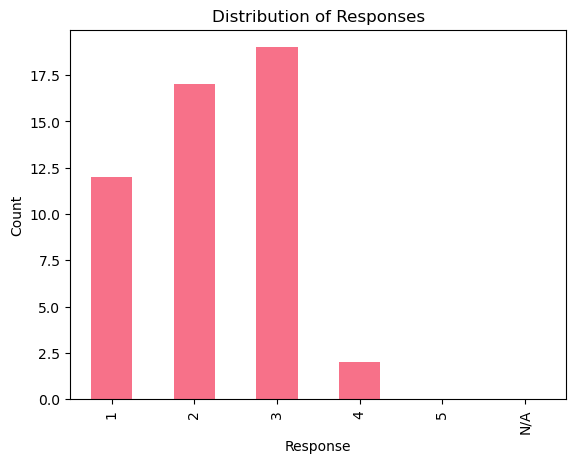

In [24]:

df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

In [25]:
# compute the average and std scores
average_score = df["response"].replace("N/A", pd.NA).astype(float).mean()
std_score = df["response"].replace("N/A", pd.NA).astype(float).std()
print(f"Average score: {average_score:.2f}")
print(f"Standard deviation of scores: {std_score:.2f}")

Average score: 2.22
Standard deviation of scores: 0.86


In [26]:
is_there_a_good_market(df)

Percentage of positive responses (4-5): 4.00%
Percentage of neutral responses (3): 38.00%
Percentage of negative responses (1-2): 58.00%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.22
Standard deviation of responses: 0.86
VERDICT: There is not a good market for bottled gazpacho.


False

We can also chat with the agents in an ad-hoc way, to get a more detailed understanding if needed.

In [27]:
from tinytroupe.ui import AgentChatJupyterWidget

# Create and display the enhanced chat widget
chat_interface = AgentChatJupyterWidget(people)
chat_interface.display()

In [28]:
control.end()

## Empirical Data Validation
Now let's see how the above matches the same research done with actual real people!

In [29]:
control_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_csv(
            file_path="../data/empirical/07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv",
            experimental_data_type="single_value_per_agent",
            agent_id_column="Responder #",
            value_column="Vote",
            agent_comments_column="Explanation",
            agent_attributes_columns=["Age Range", "Gender Identity", "Political Affiliation", "Racial Or Ethnic Identity"],
            dataset_name="Test Gazpacho Survey"
        )

In [30]:
control_data

SimulationExperimentDataset(name='Test Gazpacho Survey', description='Empirical data loaded from 07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv', key_results={'Vote': [4, 1, 1, 5, 3, 4, 2, 4, 1, 1, 3, 2, 2, 5, 4, 3, 3, 5, 4, 2, 3, 5, 3, 3, 5, 1, 3, 4, 3, 1, 1, 4, 3, 3, 2, 1, 4, 3, 4, 2, 1, 1, 2, 1, 2, 5, 2, 4, 3, 5]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 5, 'num_ranks': 5, 'rank_values': [1, 2, 3, 4, 5], 'direction': 'ascending'}}, agent_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'], agent_justifications=[{'agent_name': '1', 'agent_index': 0, 'justification': 'Yes because it is something i have nev

<Axes: xlabel='0'>

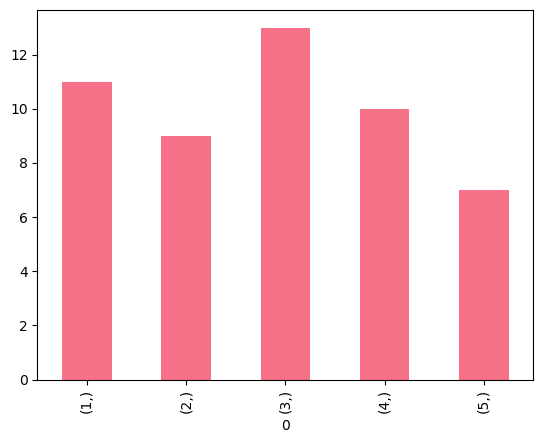

In [31]:
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind="bar")

In [32]:
# Convert string responses to numeric values and rename column to match control_data
df_for_validation = df.copy()
df_for_validation["Vote"] = pd.to_numeric(df_for_validation["response"], errors='coerce')

# Create treatment data with matching column name and data type
treatment_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_dataframe(
    df=df_for_validation,
    experimental_data_type="single_value_per_agent",
    agent_id_column="name",
    value_column="Vote",
    agent_comments_column="justification",
    dataset_name="Bottled Gazpacho Simulation Results"
)

In [33]:
treatment_data

SimulationExperimentDataset(name='Bottled Gazpacho Simulation Results', description='Empirical data loaded from pandas DataFrame', key_results={'Vote': [3, 3, 2, 2, 3, 2, 3, 3, 1, 3, 3, 2, 2, 3, 2, 4, 1, 1, 2, 2, 1, 1, 3, 3, 1, 3, 1, 4, 3, 3, 3, 3, 3, 3, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 3, 2, 3, 1, 2]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 4, 'num_ranks': 4, 'rank_values': [1, 2, 3, 4], 'direction': 'ascending'}}, agent_names=['Aiyana Marisol Redfeather-Montoya', 'Eleanor Vivian Prescott', 'Leroy Darnell McCoy Jr.', 'Eleanor Vivian Prescott-Sullivan', 'Eleanor Margaret Winslow-Sterling', 'Isabel Marquez Santoro', 'Isabela Fernanda Morales Cruz', 'Sora Emi Takahashi', 'Evelyn Grace McAllister', 'Aiyana Soleil Redhawk-Montoya', 'Clara Meredith Winslow', 'Clifton James McAllister', 'Clifton Ray Hargrove', 'Jordan Kai Redfeather-Montoya', 'Marisol Elena Vargas', 'E

In [34]:
result_ttest = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        output_format="values"
    )

In [35]:
result_ttest.overall_score

0.6397593058598363

In [36]:
result_ttest.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Welch t-test (unequal variance)',
    'control_mean': 2.86,
    'treatment_mean': 2.22,
    'mean_difference': -0.6399999999999997,
    'percent_change': -22.377622377622366,
    't_statistic': 2.8154392663034447,
    'p_value': 0.006080213300993557,
    'confidence_interval': (-1.092111958103589, -0.18788804189641034),
    'confidence_level': 0.95,
    'significant': True,
    'degrees_of_freedom': 83.17895147829783,
    'control_sample_size': 50,
    'treatment_sample_size': 50,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.8640200300021394,
    'effect_size': -0.5630878532606889}}},
 'test_type': 'welch_t_test',
 'significance_level': 0.05}

In [37]:
result_ttest.semantic_results

In [38]:
result_ks = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        statistical_test_type="ks_test",
        output_format="values"
    )

In [39]:
result_ks.overall_score

0.7692307692307692

In [40]:
result_ks.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Kolmogorov-Smirnov test',
    'control_mean': 2.86,
    'treatment_mean': 2.22,
    'control_median': 3.0,
    'treatment_median': 2.0,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.8640200300021394,
    'ks_statistic': 0.3,
    'p_value': 0.02170784069014051,
    'significant': True,
    'control_sample_size': 50,
    'treatment_sample_size': 50,
    'effect_size': 0.3,
    'overlap_coefficient': 0.5384615384615384,
    'percentile_differences': {'p25_diff': 0.0,
     'p50_diff': -1.0,
     'p75_diff': -1.0,
     'p90_diff': -2.0,
     'p95_diff': -2.0},
    'interpretation': 'Moderate difference between distributions',
    'confidence_level': 0.95}}},
 'test_type': 'ks_test',
 'significance_level': 0.05}

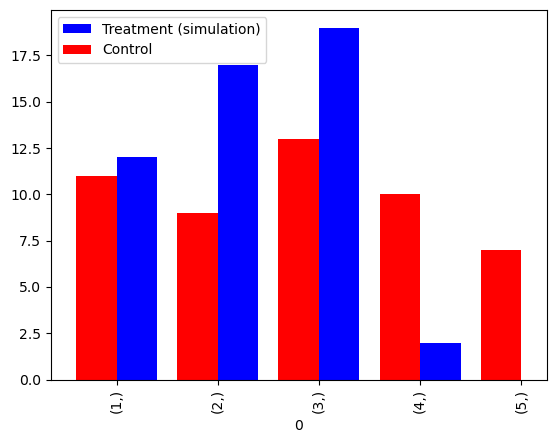

In [41]:
# compare charts. Put both bars in the same plot, for easier comparison
# Need to order the labels in the chart.
fig, ax = plt.subplots()
df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar', color='blue', position=0, width=0.4, label="Treatment (simulation)", ax=ax)
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind='bar', color='red', position=1, width=0.4, label="Control", ax=ax)
plt.legend()
plt.show()